# Regras de associação - Caso corporativo

**Nota**: Substituir __aliases__: a. `{esquema_cliente}`: nome da base do respectivo cliente; b. `{numero}` por número.

Itens de pedido por pedido e produto:

<details>
    <summary>
    SQL
    </summary>
    
    ```
    select
        pedi.pedi_data_cadastro as pedi_data,
        concat(pedi.pedi_id, '.client_{numero}') as pedi_id,
        pedi.pedi_cont_id as pedi_cliente,
        concat(prod.prod_cont_id, '.', prod.prod_codigo) as prod_id,
        prod.prod_preco,
        peit.peit_qtde,
        prod.prod_descricao
    from {esquema_cliente}.pedido_item peit
    join {esquema_cliente}.produto prod
    on prod.prod_id = peit.peit_prod_id
    join {esquema_cliente}.pedido pedi
    on pedi.pedi_id = peit.peit_pedi_id
    where pedi.pedi_data_cadastro <> '-Infinity' and
          pedi.pedi_cont_id IS NOT NULL
    order by 1
    ```
</details>



## 1. Constantes

In [11]:
MIN_SET_SIZE_CONFIDENCE = 0.95
CONFIDENCE = 0.99

MIN_BIN_COUNT = 50
MIN_SUPPORT_THRES = 0.008
MIN_THRESHOLD = 0.5
SAMPLE_COUNT = 3

NEIGHBORS_COUNT_DEFAULT = 5 
N_SUGGESTIONS_DEFAULT = 3
N_BEST_NEIGHBORS_DEFAULT = 6

dataset_pkl_filepath = 'datasets.pkl'
analysis_pkl_filepath = 'analysis_data.pkl'
graph_pkl_filepath='product_graphs.pkl'
neighbors_pkl_filepath='neighbors.pkl'
metrics_pkl_filepath='metrics.pkl'
descriptions_pkl_filepath='descriptions.pkl' 

## 2. Bibliotecas

In [12]:
import os
from os import getcwd, path, listdir
from typing import List, Union, Tuple
from warnings import warn

from tqdm import tqdm 
from alive_progress import alive_bar
from about_time import about_time
from timy import timer, Timer
from random import sample
from collections import defaultdict, Counter

import pickle
import cloudpickle
import dill

import time
from timy import timer
from numpy import unique, quantile
import pandas as pd
import polars as pl
import numpy as np
from random import sample

import matplotlib.pyplot as plt
import plotly.express as px

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


## 3. Utilitários

### Propósito amplo

In [48]:
def get_filename(filename: str):
    filename_ = filename.split('/')[-1]
    
    return filename_

def extend_filename(filename: str, token: str, delimiter: str = '.'):
    extension = filename.split(delimiter)[-1]
    body = filename.split(delimiter)[:-1]
    
    new_filename = delimiter.join(body)+'_'+token+delimiter+extension

    return new_filename

def invert_dict(dict_: dict):
    new_dict = dict()
    
    for key, value in dict_.items():
        if(isinstance(value, list)):
            for el in value:
                new_dict_key = list(new_dict.keys())
                if(el in new_dict_key):
                    new_dict[el].append(key)
                else:
                    new_dict[el] = [key]

        else:
            emsg = 'All values must be lists!'
            raise ValueError(emsg)

    return new_dict

def flatten_list(lst : list):
    new_lst = []
    
    for el in lst:
        if(isinstance(el, list)):
            new_lst+=flatten_list(el)
        else:
            new_lst.append(el)
    
    return new_lst

def sum_dicts(dict_list):
    result = {}
    for d in dict_list:
        for key, value in d.items():
            if key not in result:
                result[key] = value
            else:
                result[key] += value
    return result

def create_folder(directory_name: str):
    from os import path
    if not path.exists(directory_name):
        os.makedirs(directory_name)
        print(f"Directory '{directory_name}' created!")
    else:
        print(f"Directory '{directory_name}' already exists.")

@timer()
def load_pickle(pkl_filepath: str) -> None:
    with open(pkl_filepath, 'rb') as f:
        return pickle.load(f)

@timer()
def dump_pickle(
    dump_file: any,
    pkl_filepath: str
) -> None:    
    # Dump training data to pickle
    with open(pkl_filepath, 'wb') as f:
        pickle.dump(dump_file, f)


@timer()
def load_dill(dill_filepath: str) -> None:
    with open(dill_filepath, 'rb') as f:
        return dill.load(f)

@timer()
def dump_dill(
    dump_file: any,
    dill_filepath: str
) -> None:    
    # Dump training data to dill
    with open(dill_filepath, 'wb') as f:
        dill.dump(dump_file, f)

@timer()
def load_cloudpickle(pkl_filepath: str) -> None:
    with open(pkl_filepath, 'rb') as f:
        return cloudpickle.load(f)

@timer()
def dump_cloudpickle(
    dump_file: any,
    pkl_filepath: str
) -> None:    
    # Dump training data to cloudpickle
    with open(pkl_filepath, 'wb') as f:
        cloudpickle.dump(dump_file, f)


### Dataframe

In [49]:
def listify_items(
    df_: pd.DataFrame,
    sets_column: str,
    items_column: str
):
    result = df_.groupby(sets_column)[items_column] \
               .apply(list) \
               .reset_index(name='items_list')

    return list(result['items_list'])

def get_years(
    df_: pd.DataFrame,
    date_column: str
):
    return list(unique(list(pd.to_datetime(df_[date_column]).dt.year)))

def get_unique_elements(
    df_: pd.DataFrame,
    column_label: str
):
    return list(unique(list(df_[column_label])))

def read_data_to_dataframe_gen(
    data_folder_: str,
    sets_column: str,
    items_column: str,
    extension: str = 'xlsx'
):
    filepaths = [
        path.join(data_folder, filename) 
        for filename in listdir(data_folder) 
        if filename.split('.')[-1] == extension
    ]
    
    dfs = []
    for filepath in filepaths:
        df_ = pd.read_excel(filepath)
        df_ = df_.dropna()

        df_p = pl.from_pandas(df_)

        # Group by 'pedi_id' and 'prod_id', and select the first occurrence of each group
        relevant_columns = [sets_column, items_column]
        filtered_df = df_p.group_by(relevant_columns).first()

        df_ = filtered_df.to_pandas()        
        
        yield filepath, df_

@timer()
def read_data_to_dataframe(
    data_folder_: str,
    sets_column: str,
    items_column: str,
    extension: str = 'xlsx'
):
    return dict(read_data_to_dataframe_gen(data_folder_, sets_column, items_column, extension))

### Estatística

In [50]:
def plot_histogram(
    lst: list, 
    title_: str, 
    x_label: str, 
    bin_count: int = None, 
    is_verbose: bool = False
):
    if bin_count is None:
        bin_count = min(len(lst), 30)  # Assuming MIN_BIN_COUNT is 30

    # Compute the histogram
    hist, bins = np.histogram(lst, bins=bin_count, density=True)

    # Compute the bin values
    bin_values = [(bins[i] + bins[i+1]) / 2 for i in range(len(hist))]

    # Create a DataFrame for the histogram data
    hist_df = pd.DataFrame({'bin': bin_values, 'count': hist})

    # Create an interactive histogram plot using Plotly Express
    fig = px.bar(hist_df, x='bin', y='count', labels={'bin': x_label, 'count': 'Frequency'}, title=title_)
    fig.show()

def quantile_(lst: list, perc: float, digits: int = 2):
    return round(quantile(lst, perc), digits)
    
def print_list_statistics(lst: Union[List[int], List[float]]) -> None:
    print(f'min    : {min(lst)}')
    print(f'25%    : {quantile_(lst, 0.25)}')
    print(f'50%    : {quantile_(lst, 0.5)}')
    print(f'75%    : {quantile_(lst, 0.75)}')
    print(f'90%    : {quantile_(lst, 0.90)}')
    print(f'95%    : {quantile_(lst, 0.95)}')
    print(f'99%    : {quantile_(lst, 0.99)}')
    print(f'max    : {max(lst)}')

def plot_confidence_histogram(
    lst: list,
    title_: str,
    x_label: str, 
    bin_count: int,
    is_verbose: bool = False
):
    if(is_verbose):
        print_list_statistics(lst)
    
    # Calculate the 99th percentile
    percentile_confidence = quantile(lst, CONFIDENCE)    
    
    # Filter out counts greater than the 99th percentile
    filtered_list = [
        count 
        for count in lst 
        if count <= percentile_confidence
    ]
    
    plot_histogram(filtered_list, title_, x_label, bin_count, is_verbose)

### Regras de associação

In [51]:
def get_descriptions(
    df_: pd.DataFrame,
    item_column: str,
    description_column: str
):
    # Drop duplicates based on 'item_column' and keep the first description
    unique_df = df_.drop_duplicates(subset=item_column, keep='first')
    
    # Create a dictionary mapping items to descriptions
    return dict(zip(unique_df[item_column], unique_df[description_column]))
    
def get_items_sample(
    df_: pd.DataFrame,
    column: str,
    sample_count: int
):
    item_ids = get_unique_elements(df_, column)
    return list(sample(item_ids, sample_count))

def get_sets_count_per_items_dict(
    df_: pd.DataFrame,
    sets_column: str,
    items_column: str
):
    result = df_.groupby(items_column)[sets_column].count().reset_index()
    result_dict = result.set_index(items_column)[sets_column].to_dict()

    return result_dict

def get_sets_count_per_items(
    df_: pd.DataFrame,
    sets_column: str,
    items_column: str
):
    # Group by items_column and count sets_column, then reset the index
    counts = df.groupby(items_column)[sets_column].count().reset_index()
    
    # Rename the count column
    counts = counts.rename(columns={sets_column: 'count'})

    # Sort the DataFrame by the count column in descending order
    counts = counts.sort_values(by='count', ascending=False)
    
    return counts

def get_sets_to_items_dict(
    df_: pd.DataFrame,
    sets_column: str,
    items_column: str
):    
    # Group by 'order_id' and aggregate 'product_id' into a list
    result = listify_items(df_, sets_column, items_column)

    # Convert to list of lists
    products_per_order = result[['items_list']].values.tolist()
    orders_id = list(result[sets_column])
    
    return {
        order_id: list(unique(lst[0]))
        for order_id, lst in zip(orders_id, products_per_order) 
    }

def get_items_support(
    sets_count_dict: dict, 
    sets_total: int
):
    return {
        item_id: sets_count/sets_total
        for item_id, sets_count in sets_count_dict.items()
    }

# Confidence(A→B) = Probability(A & B) / Support(A)
def get_items_confidence(
    item_to_neighbors_dict: dict,
    items_support_dict: dict,
    sets_total: int
):    
    
    neighbors_support_dict = {
        item_id: {
            neighbor_id: neighbor_count/sets_total
            for neighbor_id, neighbor_count in neighbors.items()
        }
        for item_id, neighbors in item_to_neighbors_dict.items()
    }
    
    return {
        item_id: {
            neighbor_id: neighbor_support/items_support_dict[item_id]
            for neighbor_id, neighbor_support in neighbors.items()
        }
        for item_id, neighbors in neighbors_support_dict.items()
    }

# Lift(A→B) = Confidence(A→B) / Support(B)
def get_items_lift(
    items_supports_dict: dict, 
    confidences_dict: dict
):
    return {
        item_id: {
            neighbor_id: neighbor_confidence/items_supports_dict[neighbor_id]
            for neighbor_id, neighbor_confidence in this_item_confidences.items()
        }
        for item_id, this_item_confidences in confidences_dict.items()
    }

def get_association_metrics(
    df_: pd.DataFrame,
    neighbors: dict,
    sets_column: str, 
    items_column: str
):
    sets_count_dict = get_sets_count_per_items_dict(df_, sets_column, items_column)
    sets_total = len(get_unique_elements(df_, sets_column))
    
    items_support = get_items_support(sets_count_dict, sets_total)
    items_confidence = get_items_confidence(neighbors, items_support, sets_total)
    items_lift = get_items_lift(items_support, items_confidence)

    # TODO: 
    # Leverage: P(A and B) - P(A) * P(B)
    # Conviction: P(A and B) / (P(A) * P(B))
    # zhang_metric: Zhang(A -> B) = P(B_given_A) - P(B)

    return {
        item_id: {
            'support': item_support,
            'neighbors': {
                neighbor_id: {
                    'confidence': neighbor_confidence,
                    'lift': items_lift[item_id][neighbor_id]
                } 
                for neighbor_id, neighbor_confidence in items_confidence[item_id].items()
            }
        }
        for item_id, item_support in items_support.items()
    }

def get_items_neighbors_count(
    df_:pd.DataFrame,
    sets_column: str,
    items_column: str
):
    item_ids = get_unique_elements(df_, items_column)
    sets_list = listify_items(df_, sets_column, items_column)

    item_neighbors = {
        item_id: defaultdict(int) for item_id in item_ids
    }
    
    for item_id in tqdm(item_ids):
        set_list_with_item_id = [
            set_list 
            for set_list in sets_list
            if item_id in set_list
        ]

        for set_list in set_list_with_item_id:
                set_list_without_item_id = list(set(set_list)-set([item_id]))
    
                for friend_id in set_list_without_item_id:
                    friend_i_value = item_neighbors[item_id][friend_id]
                    item_neighbors[item_id][friend_id] = friend_i_value + 1
            

    return {
        key: value
        for key, value in item_neighbors.items()
        if len(value) != 0
    }

def get_n_best_neighbors(
    neighbors: dict,
    best_neighbor_count: int = NEIGHBORS_COUNT_DEFAULT
):
    # Prune 
    max_count = max(1, best_neighbor_count)
    n_best_neighbors = {
        neighbor_id: dict(
            [
                item
                for item in sorted(
                    neighbors[neighbor_id].items(), 
                    key=lambda x: x[1], 
                    reverse=True
                )[:max_count]
            ] 
        )
        for neighbor_id in neighbors
    }

    return n_best_neighbors

def get_k_best_arbitrary_neighbors(
    order: list,
    neighbors: dict,
    n_suggestions: dict,
    n_best_neighbors: int,
):
    n_best_neighbors = get_n_best_neighbors(neighbors, n_best_neighbors)

    def get_best_neighbor(item_id: str):
        try:
            return n_best_neighbors[item_id]
        except KeyError:
            return {}

    all_suggestions = list(
        set(
            flatten_list(
                [
                    list(get_best_neighbor(item_id).keys()) for item_id in order
                ]
            )
        )
    )
    
    suggestions = all_suggestions[:n_suggestions]
    
    return list(set(suggestions) - set(order))

def get_k_best_random_neighbors(
    order: list,
    neighbors: dict,
    n_suggestions: dict,
    n_best_neighbors: int,
):
    n_best_neighbors = get_n_best_neighbors(neighbors, n_best_neighbors)

    def get_best_neighbor(item_id: str):
        try:
            return n_best_neighbors[item_id]
        except KeyError:
            return {}

    all_suggestions = list(
        set(
            flatten_list(
                [
                    list(get_best_neighbor(item_id).keys()) for item_id in order
                ]
            )
        )
    )
    
    suggestions = sample(all_suggestions, n_suggestions)
    
    return list(set(suggestions) - set(order))

def get_k_best_support_based_neighbors(
    order: list,
    neighbors_: dict,
    sets_count_dict: dict,
    n_suggestions: dict,
    n_best_neighbors: int,
):
    sets_total = len(neighbors_.keys())
    
    n_best_neighbors = get_n_best_neighbors(neighbors_, n_best_neighbors)

    def get_best_neighbor(item_id: str):
        try:
            return n_best_neighbors[item_id]
        except KeyError:
            return {}

    count_dict = defaultdict()
    for neighbor_id, count in flatten_list(
        [
            list(get_best_neighbor(item_id).items()) 
            for item_id in order
        ]
    ):
        try:
            count_dict[neighbor_id] = max(count_dict[neighbor_id], count)
        except KeyError:
            count_dict[neighbor_id] = count            
    
    suggestion = [
        best_neighbor_j
        for best_neighbor_j, count_j in sorted(
            count_dict.items(), 
            key=lambda x: x[1], 
            reverse=True
        )
    ][:n_suggestions]

    return list(set(suggestion) - set(order))

def get_neighbors_count_per_item(
    df: pl.DataFrame, 
    sets_column: str, 
    item_column: str
):
    # Group by 'prod_id' and collect a list of 'pedi_id' for each group
    grouped = df.group_by(item_column).agg(sets_column)
    
    # Create an empty DataFrame to store the product co-occurrence counts
    final_df_cols = {
        item_column: str,
        "neighbors": str, 
        "count": int
    }
    count_df = pl.DataFrame(schema=final_df_cols, orient='col')
    
    # Iterate over each group
    for prod_id, pedi_ids in tqdm(grouped.rows()):
        
        # Filter the DataFrame to rows with pedi_ids in the current group
        filtered_df = df.filter(pl.col(sets_column).is_in(pedi_ids))
        
        # Calculate co-occurrence counts for each pedi_id in the group
        cooccurrence_counts = filtered_df.group_by(item_column)\
                                         .count()\
                                         .filter(pl.col(item_column) != prod_id)
        
        # Reshape the co-occurrence counts for each pedi_id into separate rows
        cooccurrence_tuples = [
            (prod_id, row[0], row[1]) 
            for row in cooccurrence_counts.rows()
        ]
        
        # Append co-occurrence counts for the current group to the result DataFrame
        this_prod_df = pl.DataFrame(cooccurrence_tuples, schema=final_df_cols)
        
        count_df = pl.concat([count_df, this_prod_df])

    return count_df

def get_frequent_items_and_rules_dict(
    filename_: str,
    df_: pd.DataFrame, 
    min_support_: float, 
    min_threshold_: float
):
    frequent_itemsets, rules = get_association_rules(
        df_, min_support_, min_threshold_
    )

    if(not rules.empty):
        create_folder('rules')
        new_filename = extend_filename(filename_, rules)
        rules.to_excel(new_filename)
    
    return {
        'frequent_itemsets': frequent_itemsets,
        'association_rules': rules
    }

@timer()
def get_association_rules(
    df_: pd.DataFrame, sets_column: str, items_column: str,
	min_support_=0.001,	min_threshold_=0.05, set_size_confidence=MIN_SET_SIZE_CONFIDENCE,
    is_verbose=True
):
    all_sets_list = listify_items(df_, sets_column, items_column)
    len_map = lambda x: len(x)
    len_sets = list(
        map(len_map, listify_items(df_, sets_column, items_column))
    )
    
    percentile_X = quantile(len_sets, set_size_confidence)
    confidence_data = list(filter(lambda x: len(x) < percentile_X, all_sets_list))
    
    # Preparação dos dados
    te = TransactionEncoder()
    te_ary = te.fit(confidence_data).transform(confidence_data)

    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Aplicando o algoritmo Apriori
    frequent_itemsets = apriori(df_encoded, min_support=min_support_, use_colnames=True)
    
    # Geração de Regras de Associação
    relevant_columns = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = min_threshold_)

    if(is_verbose):
        print(f'Comprimento de pedidos originais : {len(all_sets_list)}')
        print(f'Comprimento de pedidos de treino : {len(confidence_data)}')
        print(f'Número de regras                 : {len(rules)}')
        print()
    
    return frequent_itemsets, rules[relevant_columns]

### Negócio

In [52]:
def sets_factory_gen(sets: list,):
    while True:
        yield sample(sets, 1)[0]

def get_client_data(
    df_: pd.DataFrame,
    is_verbose: bool = False
):
    order_ids = get_unique_elements(df_, 'pedi_id')
    orders_list = listify_items(df_, 'pedi_id', 'prod_id')
    
    product_ids = get_unique_elements(df_, 'prod_id')
    products_to_orders_ = get_sets_to_items_dict(df_, 'pedi_id', 'prod_id')
    
    count_products_ = [
        len(order_ids)
        for product_id, order_ids in products_to_orders_.items()
    ]

    # Calculate the quantiles
    q1 = quantile(count_products_, 0.25)

    # Median
    q2 = quantile(count_products_, 0.50)
    
    q3 = quantile(count_products_, 0.75)

    if(is_verbose):
        print(f'Contagem de pedidos  : {len(order_ids)}')
        print(f'Contagem de produtos  : {len(product_ids)}')
        print("Q1 (25%)             :", q1)
        print("Q2 (50%, median)     :", q2)
        print("Q3 (75%)             :", q3)

    order_to_products = get_sets_to_items_dict(df_, 'pedi_id', 'prod_id')
    product_to_orders = invert_dict(order_to_products)
    products_per_orders_list_ = list(order_to_products.values())

    return {
        'orders': {
            'count': len(order_ids),
            'ids': order_ids,
            'list': orders_list,
            'order_to_products': order_to_products
        },
        'products': {
            'count': len(product_ids),
            'ids': product_ids,
            'quantiles': [q1, q2, q3],
            'product_to_orders': product_to_orders
        }
    }

def get_company_data(
    filename: str,
    df_: pd.DataFrame
):
    client_ids_ = get_unique_elements(df_, 'pedi_cliente')

    clients_data = dict()
    for client_id in tqdm(client_ids_):    
        client_mask = df_['pedi_cliente'] == client_id
        df_client = df_[client_mask]
        clients_data[client_id] = get_client_data(df_client)

    company_data = get_client_data(df_)
    
    company_info = {
        'general': company_data,
        'clients': clients_data
    }
    
    return company_info


## 4. Carregamento e transformação de dados

In [ ]:
data_folder = getcwd()+'/data/'

filename_dfs = dict(read_data_to_dataframe(data_folder, 'pedi_id', 'prod_id'))

In [14]:
dfs = list(filename_dfs.values())
filenames = list(filename_dfs.keys())

In [ ]:
dump_pickle(filename_dfs, dataset_pkl_filepath)

In [ ]:
products_ = dict()

assets_folder = getcwd() + '/assets'

create_folder(assets_folder)

with about_time() as t:
    for filename, df_ in filename_dfs.items():
        filename_ = get_filename(filename)

        most_sold_items = get_sets_count_per_items(df_, 'pedi_id', 'prod_id')

        new_filename = extend_filename(filename_, 'mais_vendidos')
        new_filepath = path.join(assets_folder, new_filename)
        
        most_sold_items.to_excel(new_filepath, index=False)
    
print(f'Produtos mais vendidos: {t.duration_human}')


In [ ]:
analysis_data = dict()

for filename, df_ in filename_dfs.items():
    analysis_data[filename] = get_company_data(filename, df_)

In [ ]:
## DEPRECATED

import polars as pl
 
product_graphs = dict()

with about_time() as t:
    for filename, df_ in filename_dfs.items():
        df_polars = pl.from_pandas(df_)        
        product_graphs[filename] = get_neighbors_count_per_item(df_polars, 'pedi_id', 'prod_id')

print(f'Grafo de produtos demorou: {t.duration_human}')

In [ ]:
dump_pickle(product_graphs, graph_pkl_filepath)

In [58]:
neighbors = defaultdict()

for filename, df in filename_dfs.items():
    neighbors[filename] = get_items_neighbors_count(
        df, 'pedi_id', 'prod_id'
    )


100%|██████████████████████████████████████| 5243/5243 [00:09<00:00, 560.15it/s]


In [60]:
dump_pickle(neighbors, neighbors_pkl_filepath)

Timy executed (dump_pickle) for 1 time in 1.304114 seconds
Timy best time was 1.304114 seconds


In [49]:
metrics = defaultdict()

with about_time() as t:
    for filename, df_n in filename_dfs.items():
        neighbors_n = neighbors[filename]
        
        metrics[filename] = get_association_metrics(df_n, neighbors_n, 'pedi_id', 'prod_id')

print(f'Métricas de associação demorou: {t.duration_human}')

Métricas de associação demorou: 8.1s


In [50]:
dump_pickle(metrics, metrics_pkl_filepath)

Timy executed (dump_pickle) for 1 time in 4.933985 seconds
Timy best time was 4.933985 seconds


In [14]:
descriptions = defaultdict()
with about_time() as t:
    for filename, df in filename_dfs.items():
        descriptions[filename] = get_descriptions(df, 'prod_id', 'prod_descricao')

In [15]:
dump_pickle(descriptions, descriptions_pkl_filepath)

Timy executed (dump_pickle) for 1 time in 0.016164 seconds
Timy best time was 0.016164 seconds


## 5. Carregamento de dados salvos

In [18]:
# Call the function to load the NumPy array
filename_dfs = load_pickle(dataset_pkl_filepath)

for df in filename_dfs.values():
    df = df.sort_values(by='pedi_data')

dfs = list(filename_dfs.values())
filenames = list(filename_dfs.keys())

Timy executed (load_pickle) for 1 time in 0.141907 seconds
Timy best time was 0.141907 seconds


In [19]:
analysis_data = load_pickle(analysis_pkl_filepath)

Timy executed (load_pickle) for 1 time in 5.931145 seconds
Timy best time was 5.931145 seconds


In [20]:
product_graphs = load_pickle(graph_pkl_filepath)

Timy executed (load_pickle) for 1 time in 0.982282 seconds
Timy best time was 0.982282 seconds


In [21]:
neighbors = load_pickle(neighbors_pkl_filepath)

Timy executed (load_pickle) for 1 time in 0.980459 seconds
Timy best time was 0.980459 seconds


In [22]:
metrics = load_pickle(metrics_pkl_filepath)

Timy executed (load_pickle) for 1 time in 4.192971 seconds
Timy best time was 4.192971 seconds


In [23]:
descriptions = load_pickle(descriptions_pkl_filepath)

Timy executed (load_pickle) for 1 time in 0.017435 seconds
Timy best time was 0.017435 seconds


## 6. _Drill down_: Investigação visual de dados

### Pedidos por ano

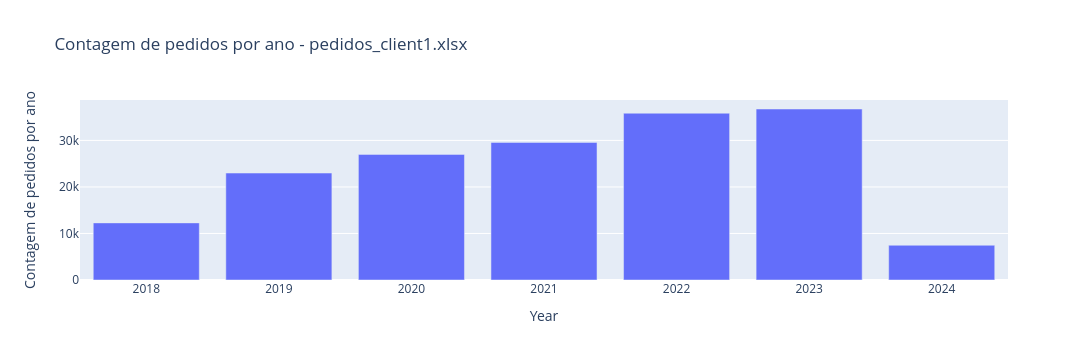

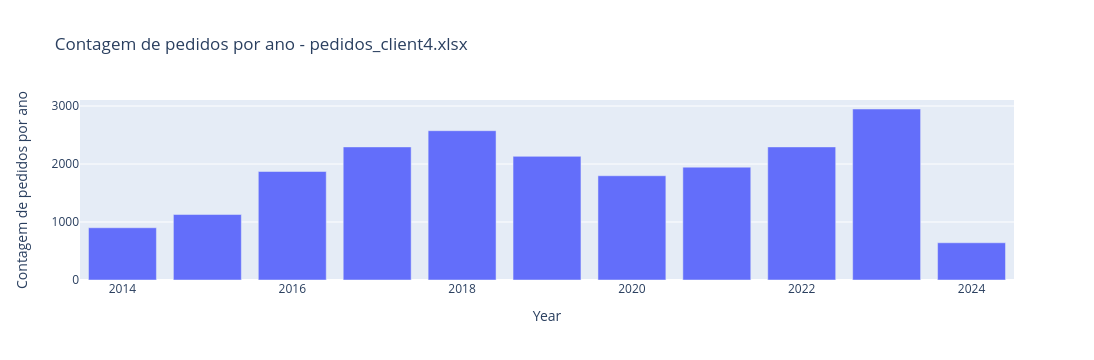

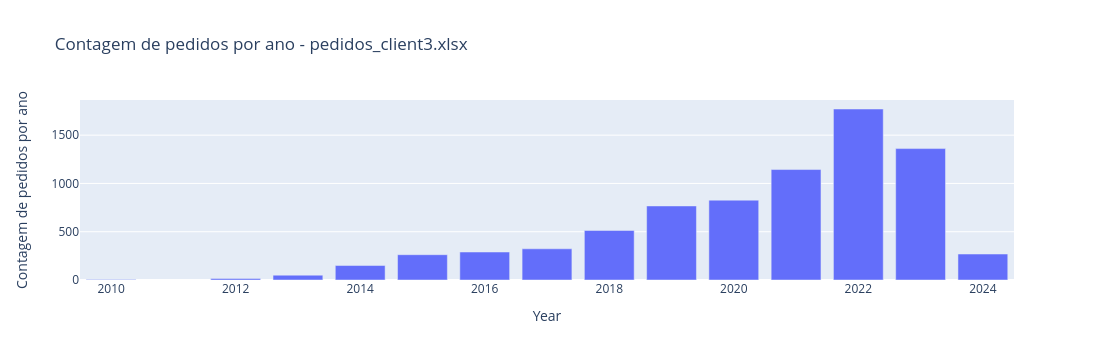

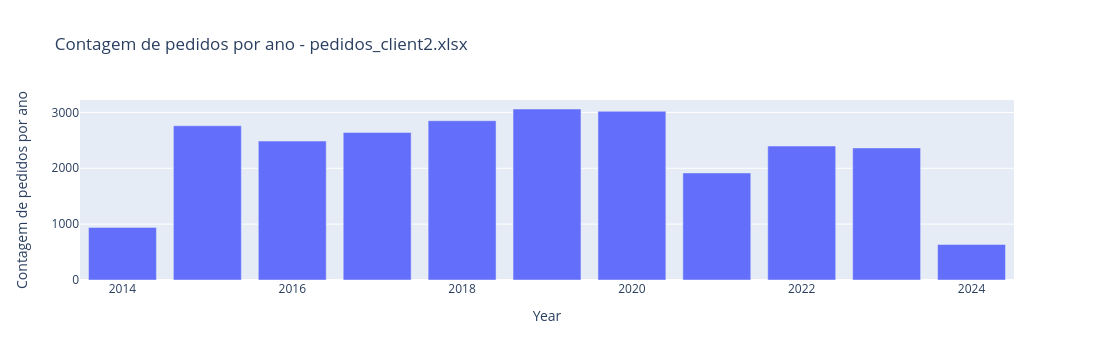

In [317]:
import pandas as pd
import plotly.express as px

for filename, df in filename_dfs.items():
    # Convert the 'pedi_data' column to datetime format
    df['pedi_data'] = pd.to_datetime(df['pedi_data'])
    
    # Obtain the year from the 'pedi_data' column
    df['year'] = df['pedi_data'].dt.year

    df_pw = df[['pedi_id', 'year']].drop_duplicates()
    counts_per_year = df_pw.groupby('year')['pedi_id'] \
                          .count() \
                          .reset_index(name='count_orders')

    # Create a bar plot using plotly.express
    filename_ = filename.split('/')[-1]

    title_ = f'Contagem de pedidos por ano - {filename_}'
    legend_ = {'year': 'Year', 'count_orders': 'Contagem de pedidos por ano'}

    fig = px.bar(
        counts_per_year, 
        x='year', y='count_orders', 
        labels=legend_, title=title_
    )

    fig.show()

### Pedidos por meses

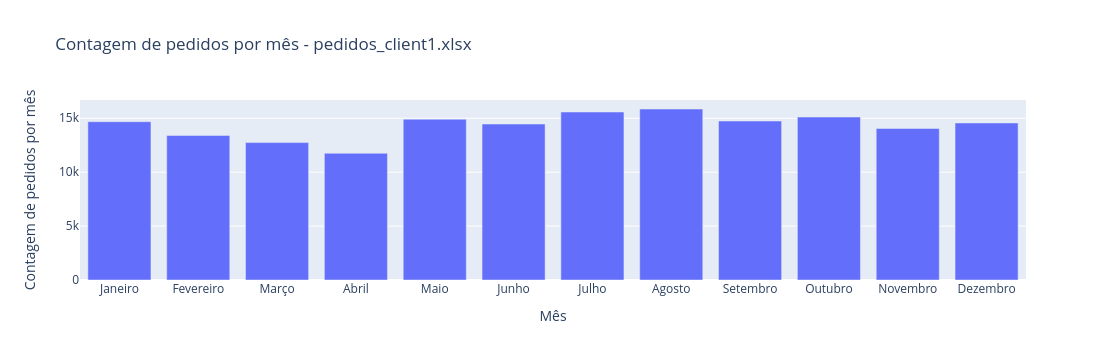

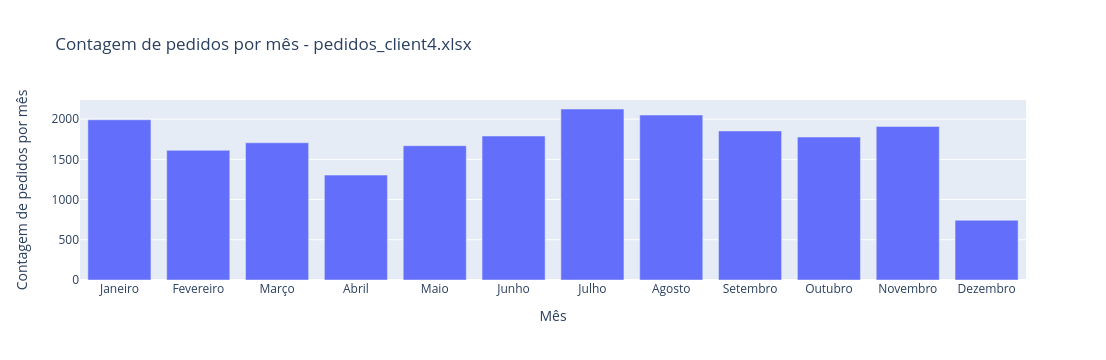

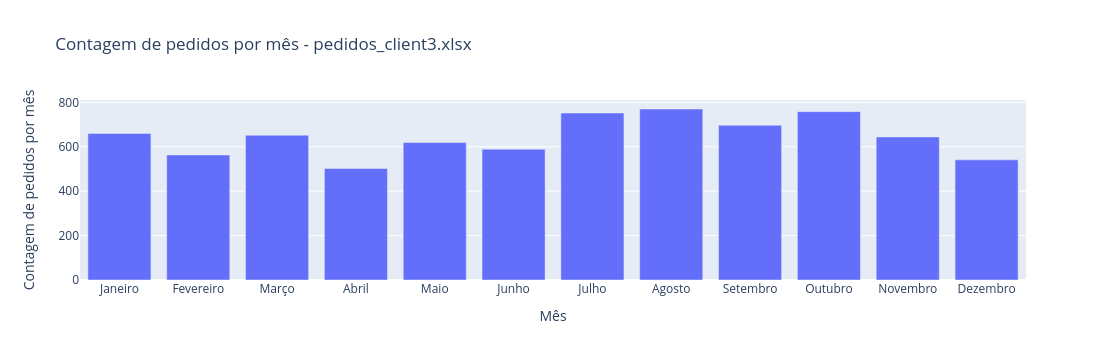

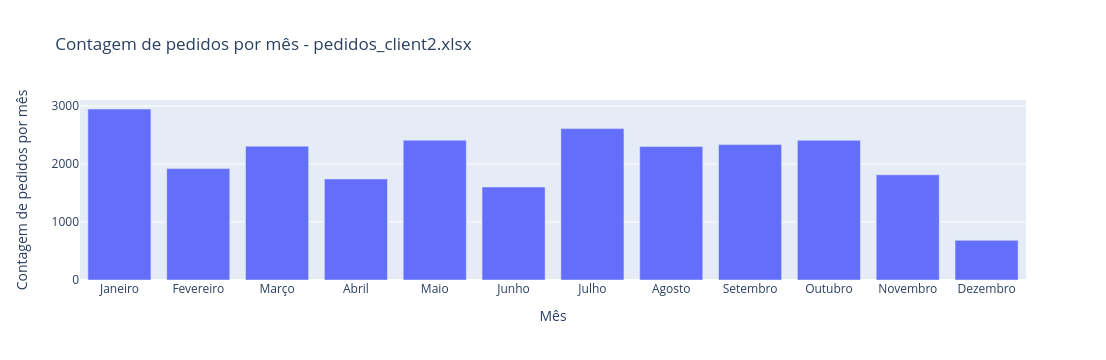

In [16]:
import pandas as pd
import plotly.express as px

# Define the order of months in Portuguese
month_order = [
    'Janeiro', 'Fevereiro', 'Março', 'Abril',
    'Maio', 'Junho', 'Julho', 'Agosto',
    'Setembro', 'Outubro', 'Novembro', 'Dezembro'
]

# Create a CategoricalDtype with the specified order
cat_dtype = pd.CategoricalDtype(categories=month_order, ordered=True)

for filename, df in filename_dfs.items():
    # Convert the 'pedi_data' column to datetime format
    df['pedi_data'] = pd.to_datetime(df['pedi_data'])
    
    # Obtain the month from the 'pedi_data' column and map to Portuguese
    df['month'] = df['pedi_data'].dt.month_name().map(month_names_mapping)
    
    # Use the CategoricalDtype to ensure correct ordering
    df['month'] = df['month'].astype(cat_dtype)

    df_pw = df[['pedi_id', 'month']].drop_duplicates()
    counts_per_month = df_pw.groupby('month')['pedi_id'] \
                          .count() \
                          .reindex(month_order) \
                          .reset_index(name='count_orders')

    # Create a bar plot using plotly.express
    filename_ = filename.split('/')[-1]

    title_ = f'Contagem de pedidos por mês - {filename_}'
    legend_ = {'month': 'Mês', 'count_orders': 'Contagem de pedidos por mês'}

    fig = px.bar(
        counts_per_month, 
        x='month', y='count_orders', 
        labels=legend_, title=title_
    )

    fig.show()


#### Pedidos por meses por ano

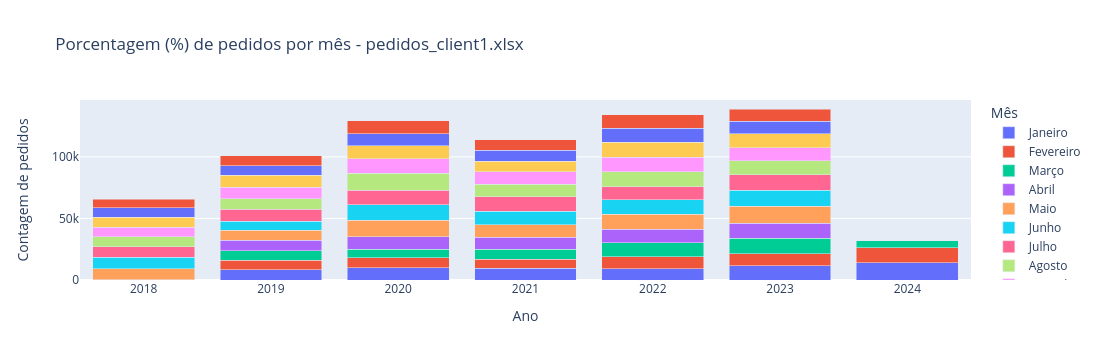

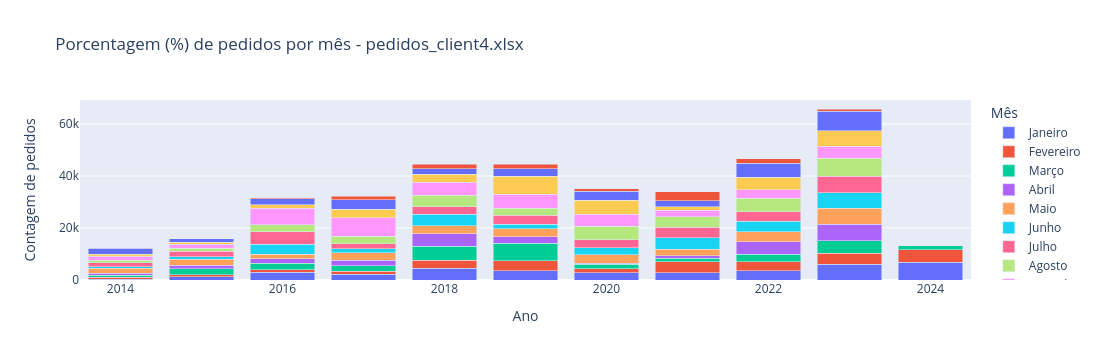

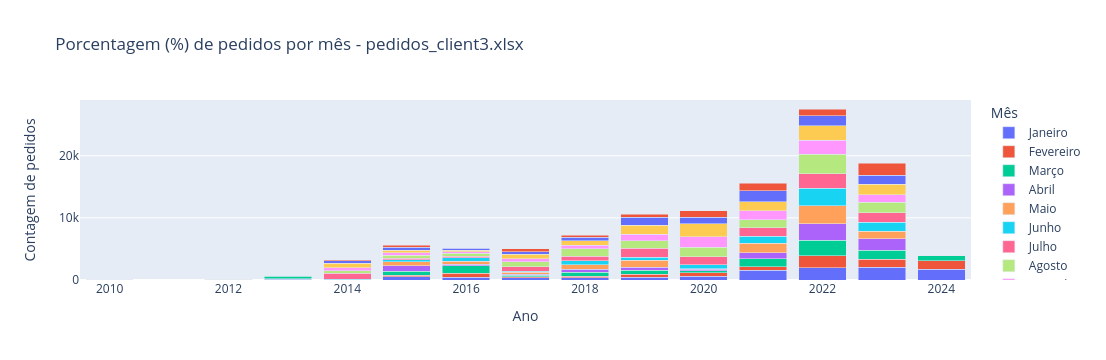

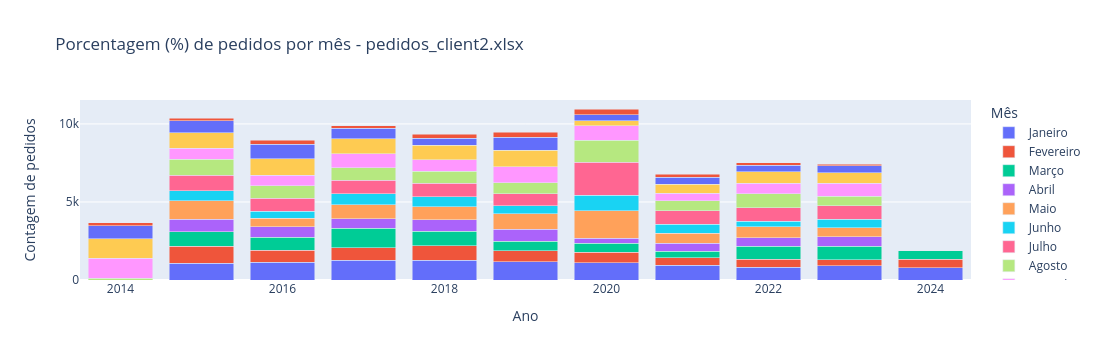

In [19]:
import pandas as pd
from collections import OrderedDict
import plotly.express as px

# Define an ordered dictionary to map English month names to Portuguese
month_map = OrderedDict([
    ('January', 'Janeiro'),
    ('February', 'Fevereiro'),
    ('March', 'Março'),
    ('April', 'Abril'),
    ('May', 'Maio'),
    ('June', 'Junho'),
    ('July', 'Julho'),
    ('August', 'Agosto'),
    ('September', 'Setembro'),
    ('October', 'Outubro'),
    ('November', 'Novembro'),
    ('December', 'Dezembro')
])

for filename, df in filename_dfs.items():
    # Convert the 'pedi_data' column to datetime format
    df['pedi_data'] = pd.to_datetime(df['pedi_data'])
    
    # Obtain the year and month from the 'pedi_data' column
    df['year'] = df['pedi_data'].dt.year
    df['month_name'] = df['pedi_data'].dt.month_name()
    
    # Map the month names to Portuguese
    df['month_name'] = df['month_name'].map(month_map)
    
    # Group by year and month_name, and count the number of orders
    counts_per_year_month = df.groupby(['year', 'month_name'])['pedi_id'].count().reset_index()
    
    # Pivot the DataFrame to have years as rows, months as columns, and order counts as values
    pivot_df = counts_per_year_month.pivot(index='year', columns='month_name', values='pedi_id').fillna(0)
    
    # Reorder the columns according to the ordered dictionary
    pivot_df = pivot_df[month_map.values()]
    
    # Create a stacked bar plot using plotly.express
    filename_ = filename.split('/')[-1]

    title_ = f'Porcentagem (%) de pedidos por mês - {filename_}'
    legend_ = {
        'year': 'Ano', 
        'value': 'Contagem de pedidos', 
        'month_name': 'Mês'
    }
    
    denormalized_fig = px.bar(
        pivot_df, 
        x=pivot_df.index, y=pivot_df.columns, 
        labels=legend_, title=title_, barmode='stack'
    )
    
    denormalized_fig.show()


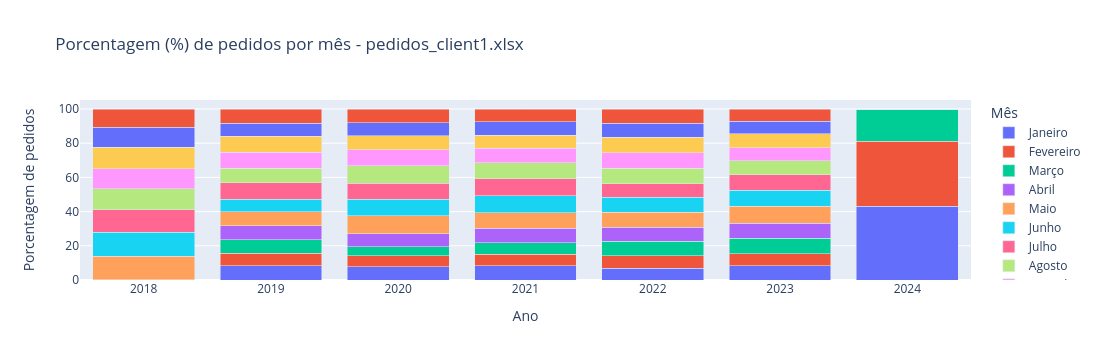

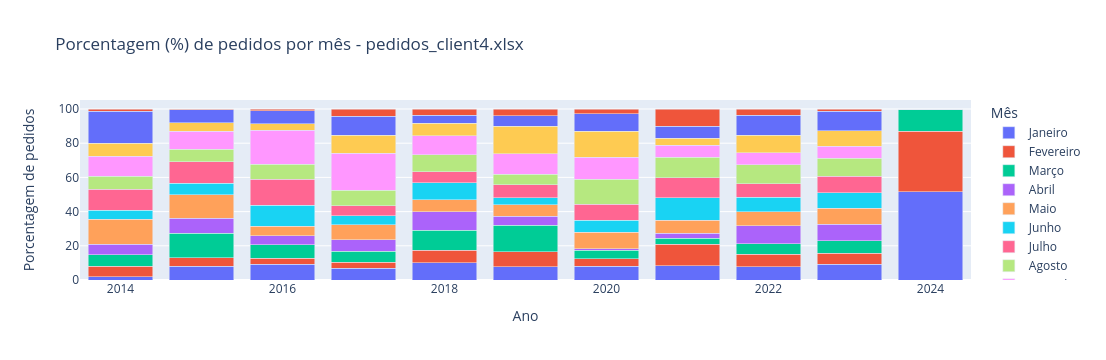

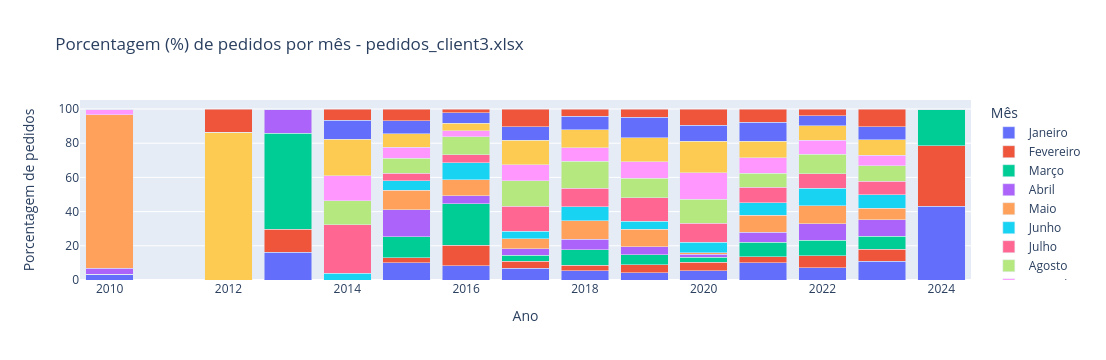

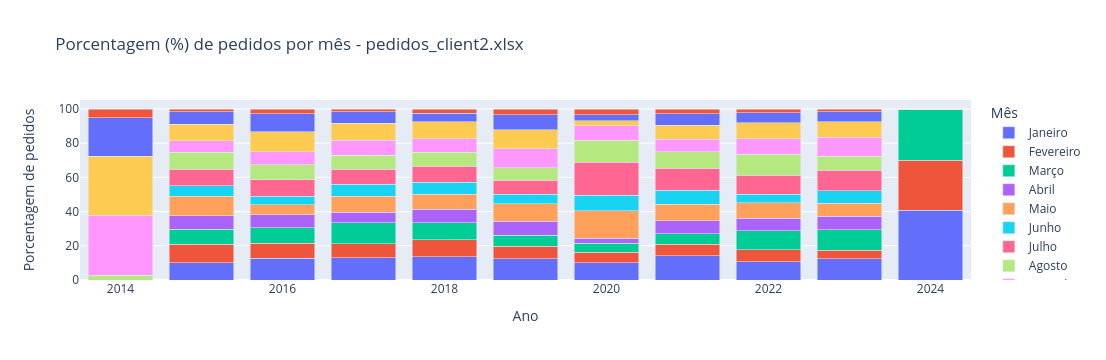

In [20]:
import pandas as pd
from collections import OrderedDict
import plotly.express as px

# Define an ordered dictionary to map English month names to Portuguese
month_map = OrderedDict([
    ('January', 'Janeiro'),
    ('February', 'Fevereiro'),
    ('March', 'Março'),
    ('April', 'Abril'),
    ('May', 'Maio'),
    ('June', 'Junho'),
    ('July', 'Julho'),
    ('August', 'Agosto'),
    ('September', 'Setembro'),
    ('October', 'Outubro'),
    ('November', 'Novembro'),
    ('December', 'Dezembro')
])

for filename, df in filename_dfs.items():
    # Convert the 'pedi_data' column to datetime format
    df['pedi_data'] = pd.to_datetime(df['pedi_data'])
    
    # Obtain the year and month from the 'pedi_data' column
    df['year'] = df['pedi_data'].dt.year
    df['month_name'] = df['pedi_data'].dt.month_name()
    
    # Map the month names to Portuguese
    df['month_name'] = df['month_name'].map(month_map)
    
    # Group by year and month_name, and count the number of orders
    counts_per_year_month = df.groupby(['year', 'month_name'])['pedi_id'].count().reset_index()
    
    # Pivot the DataFrame to have years as rows, months as columns, and order counts as values
    pivot_df = counts_per_year_month.pivot(index='year', columns='month_name', values='pedi_id').fillna(0)
    
    # Calculate the total number of orders for each year
    pivot_df['total_orders'] = pivot_df.sum(axis=1)
    
    # Normalize the order counts for each month within each year
    for month in month_map.values():
        pivot_df[month] = (pivot_df[month] / pivot_df['total_orders']) * 100
    
    # Reorder the columns according to the ordered dictionary
    pivot_df = pivot_df[month_map.values()]
    
    # Create a stacked bar plot using plotly.express
    filename_ = filename.split('/')[-1]

    title_ = f'Porcentagem (%) de pedidos por mês - {filename_}'
    legend_ = {
        'year': 'Ano', 
        'value': 'Porcentagem de pedidos', 
        'month_name': 'Mês'
    }
    
    normalized_fig = px.bar(
        pivot_df, 
        x=pivot_df.index, y=pivot_df.columns, 
        labels=legend_, title=title_, barmode='stack'
    )
    
    normalized_fig.show()


### Pedidos por dias da semana

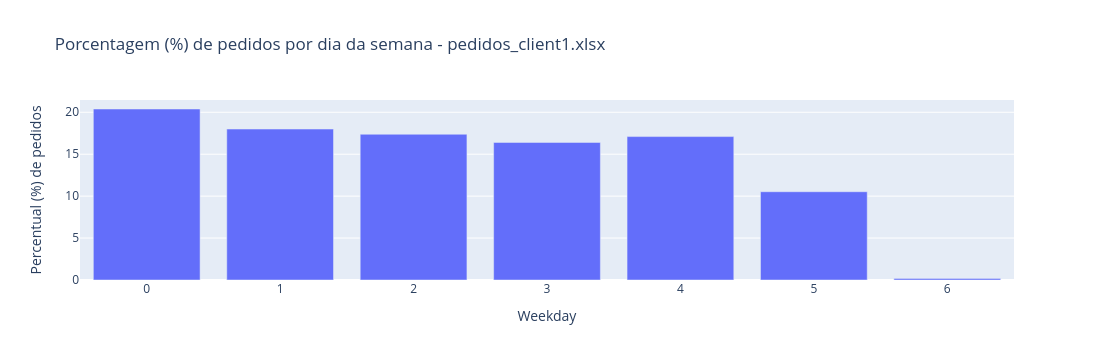

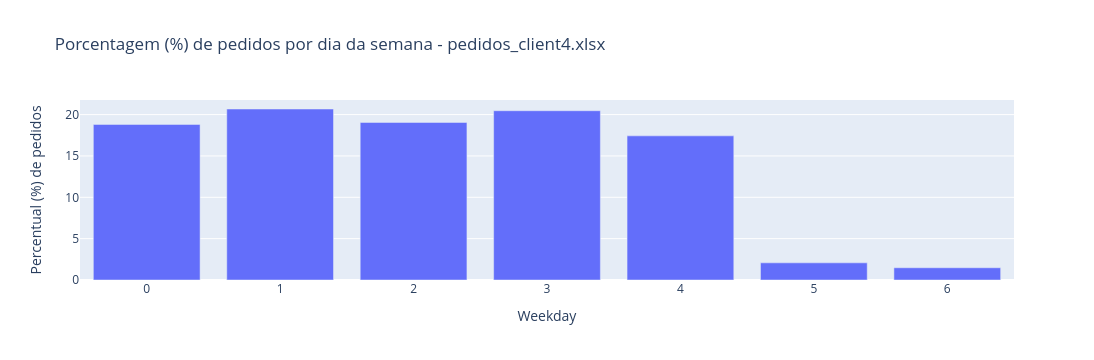

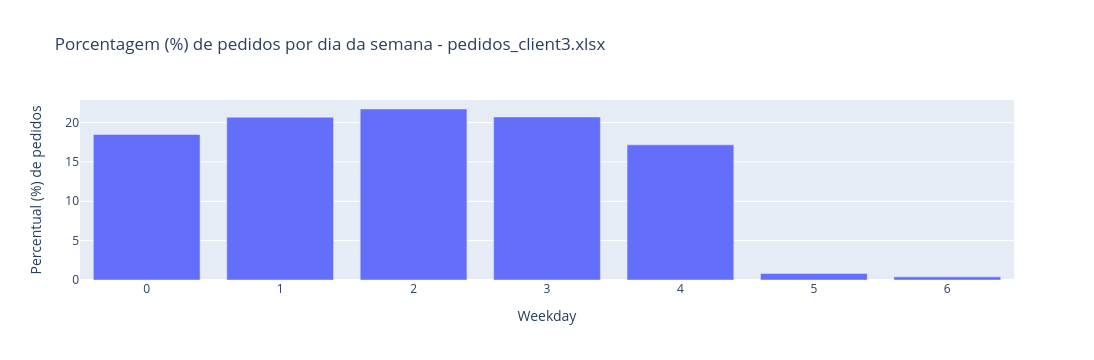

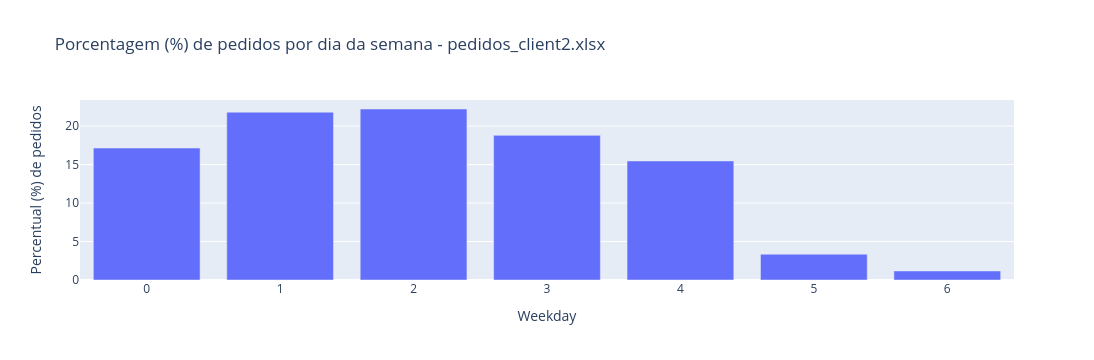

In [230]:
for filename, df in filename_dfs.items():

    # Convert the 'date' column to datetime format
    df['pedi_data'] = pd.to_datetime(df['pedi_data'])
    
    # Obtain the weekday (Monday=0, Sunday=6) from the 'date' column
    df['weekday_name'] = df['pedi_data'].dt.day_name()
    df['weekday'] = df['pedi_data'].dt.weekday

    df_pw = df[['pedi_id', 'weekday']].drop_duplicates()
    counts_per_weekday = df_pw.groupby('weekday')['pedi_id'] \
                              .count() \
                              .reset_index(name='count_orders')

    # Calculate the total number of orders
    total_orders = counts_per_weekday['count_orders'].sum()
    
    # Normalize the counts to percentage
    counts_per_weekday['normalized'] = (counts_per_weekday['count_orders'] / total_orders) * 100
    
    # Create a bar plot using plotly.express
    filename_ = filename.split('/')[-1]

    title_ = f'Porcentagem (%) de pedidos por dia da semana - {filename_}'
    legend_ = {'weekday': 'Weekday', 'normalized': 'Percentual (%) de pedidos'}

    fig = px.bar(
        counts_per_weekday, 
        x='weekday', y='normalized', 
        labels=legend_, title=title_
    )

    fig.show()

#### Dias da semana por ano

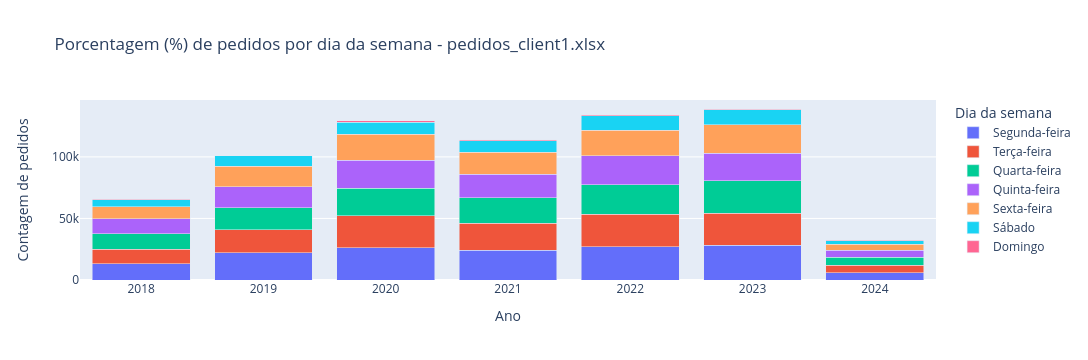

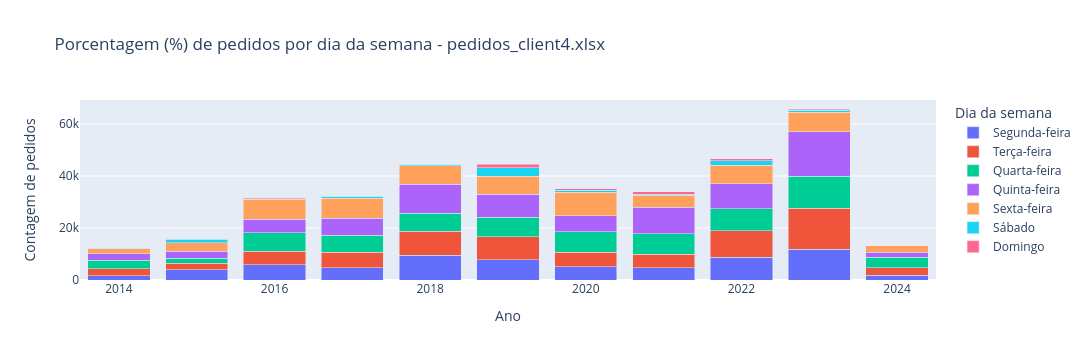

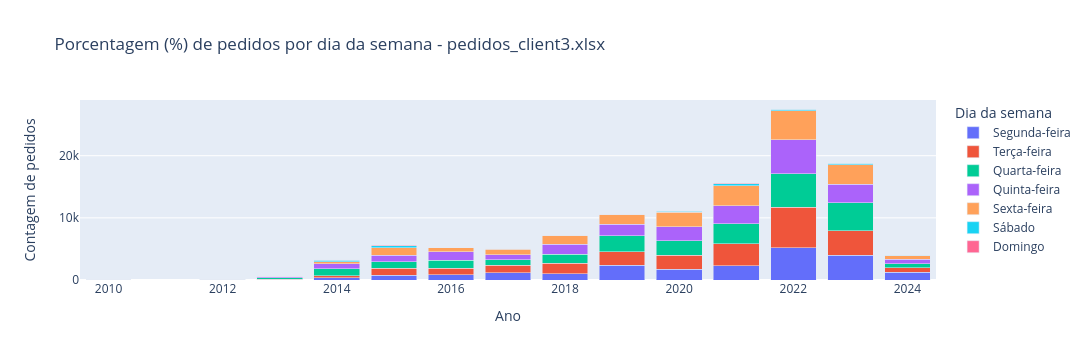

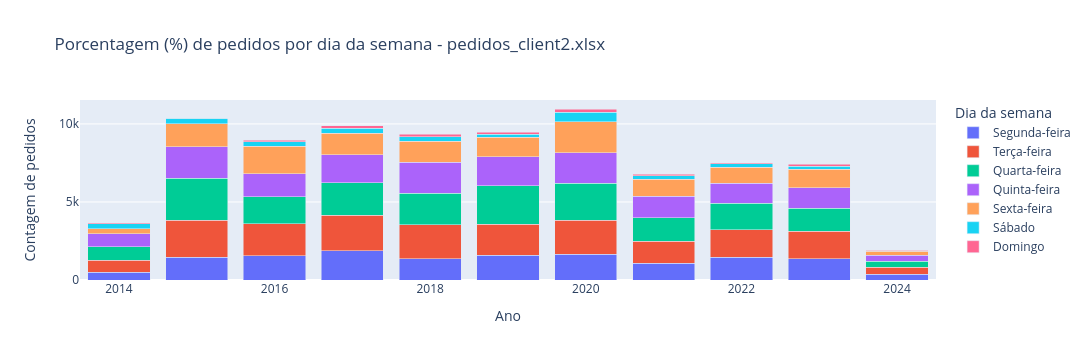

In [318]:
import pandas as pd
from collections import OrderedDict
import plotly.express as px

# Define an ordered dictionary to map English weekday names to Portuguese
weekday_map = OrderedDict([
    ('Monday', 'Segunda-feira'),
    ('Tuesday', 'Terça-feira'),
    ('Wednesday', 'Quarta-feira'),
    ('Thursday', 'Quinta-feira'),
    ('Friday', 'Sexta-feira'),
    ('Saturday', 'Sábado'),
    ('Sunday', 'Domingo')
])

for filename, df in filename_dfs.items():
    # Convert the 'pedi_data' column to datetime format
    df['pedi_data'] = pd.to_datetime(df['pedi_data'])
    
    # Obtain the year and weekday from the 'pedi_data' column
    df['year'] = df['pedi_data'].dt.year
    df['weekday_name'] = df['pedi_data'].dt.day_name()
    
    # Map the weekday names to Portuguese
    df['weekday_name'] = df['weekday_name'].map(weekday_map)
    
    # Group by year and weekday_name, and count the number of orders
    counts_per_year_weekday = df.groupby(['year', 'weekday_name'])['pedi_id'].count().reset_index()
    
    # Pivot the DataFrame to have years as rows, weekdays as columns, and order counts as values
    pivot_df = counts_per_year_weekday.pivot(index='year', columns='weekday_name', values='pedi_id').fillna(0)
    
    # Reorder the columns according to the ordered dictionary
    pivot_df = pivot_df[weekday_map.values()]
    
    # Create a stacked bar plot using plotly.express
    filename_ = filename.split('/')[-1]

    title_ = f'Porcentagem (%) de pedidos por dia da semana - {filename_}'
    legend_ = {
        'year': 'Ano', 
        'value': 'Contagem de pedidos', 
        'weekday_name': 'Dia da semana'
    }
    
    denormalized_fig = px.bar(
        pivot_df, 
        x=pivot_df.index, y=pivot_df.columns, 
        labels=legend_, title=title_, barmode='stack'
    )
    
    denormalized_fig.show()


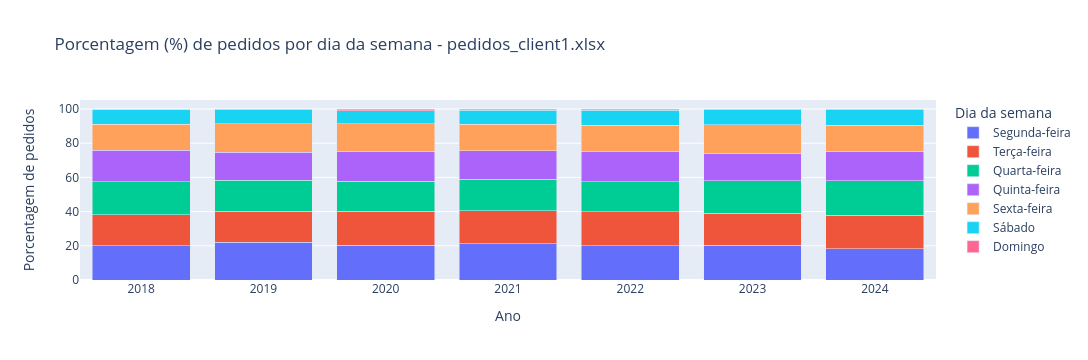

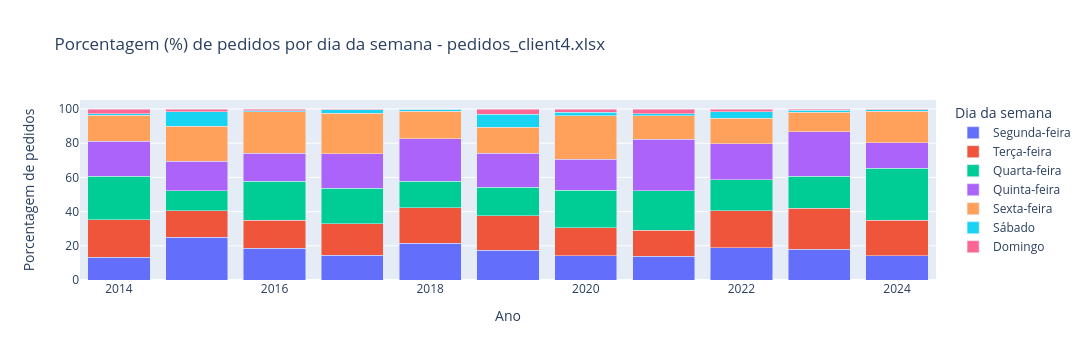

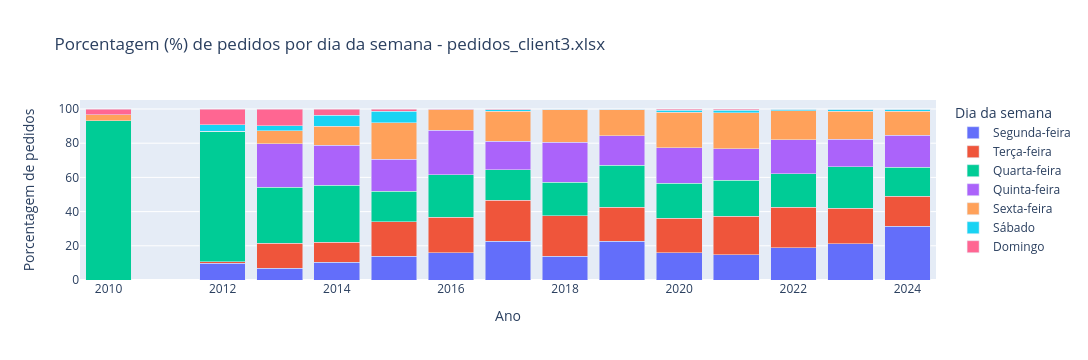

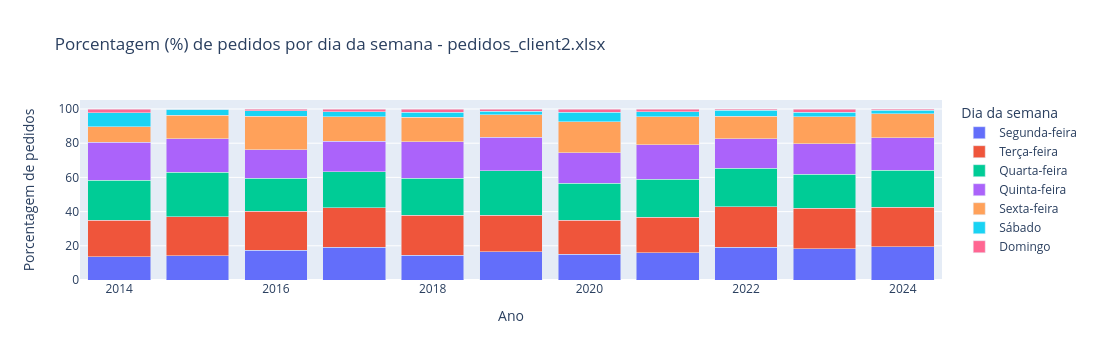

In [260]:
import pandas as pd
from collections import OrderedDict
import plotly.express as px

# Define an ordered dictionary to map English weekday names to Portuguese
weekday_map = OrderedDict([
    ('Monday', 'Segunda-feira'),
    ('Tuesday', 'Terça-feira'),
    ('Wednesday', 'Quarta-feira'),
    ('Thursday', 'Quinta-feira'),
    ('Friday', 'Sexta-feira'),
    ('Saturday', 'Sábado'),
    ('Sunday', 'Domingo')
])

for filename, df in filename_dfs.items():
    # Convert the 'pedi_data' column to datetime format
    df['pedi_data'] = pd.to_datetime(df['pedi_data'])
    
    # Obtain the year and weekday from the 'pedi_data' column
    df['year'] = df['pedi_data'].dt.year
    df['weekday_name'] = df['pedi_data'].dt.day_name()
    
    # Map the weekday names to Portuguese
    df['weekday_name'] = df['weekday_name'].map(weekday_map)
    
    # Group by year and weekday_name, and count the number of orders
    counts_per_year_weekday = df.groupby(['year', 'weekday_name'])['pedi_id'].count().reset_index()
    
    # Pivot the DataFrame to have years as rows, weekdays as columns, and order counts as values
    pivot_df = counts_per_year_weekday.pivot(index='year', columns='weekday_name', values='pedi_id').fillna(0)
    
    # Calculate the total number of orders for each year
    pivot_df['total_orders'] = pivot_df.sum(axis=1)
    
    # Normalize the order counts for each weekday within each year
    for weekday in weekday_map.values():
        pivot_df[weekday] = (pivot_df[weekday] / pivot_df['total_orders']) * 100
    
    # Reorder the columns according to the ordered dictionary
    pivot_df = pivot_df[weekday_map.values()]
    
    # Create a stacked bar plot using plotly.express
    filename_ = filename.split('/')[-1]

    title_ = f'Porcentagem (%) de pedidos por dia da semana - {filename_}'
    legend_ = {
        'year': 'Ano', 
        'value': 'Porcentagem de pedidos', 
        'weekday_name': 'Dia da semana'
    }
    
    normalized_fig = px.bar(
        pivot_df, 
        x=pivot_df.index, y=pivot_df.columns, 
        labels=legend_, title=title_, barmode='stack'
    )
    
    normalized_fig.show()

### Tamanho do pedido

min    : 1
25%    : 1.0
50%    : 2.0
75%    : 4.0
90%    : 9.0
95%    : 16.0
99%    : 39.0
max    : 637


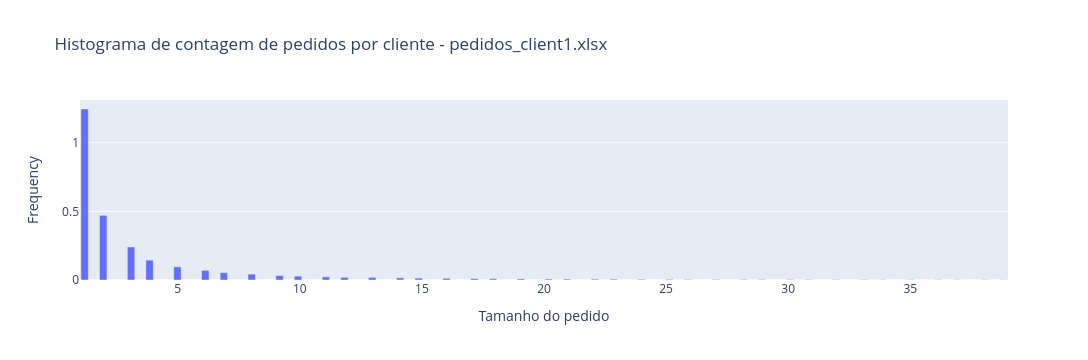

min    : 1
25%    : 3.0
50%    : 10.0
75%    : 25.0
90%    : 46.0
95%    : 61.0
99%    : 101.0
max    : 418


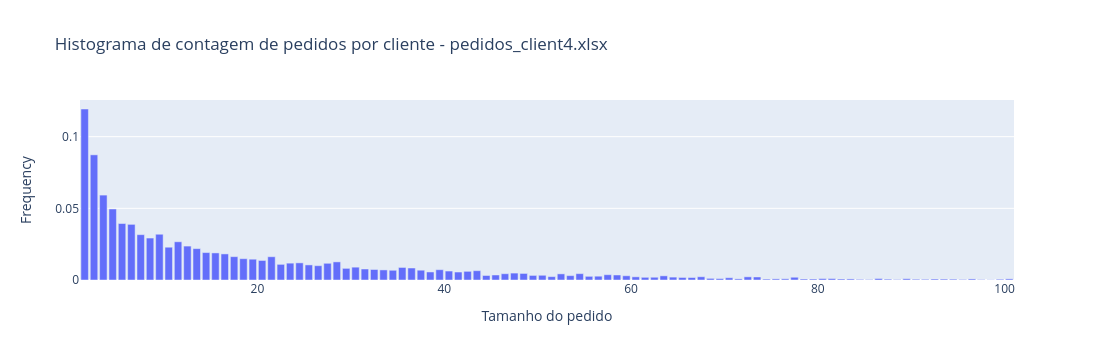

min    : 1
25%    : 2.0
50%    : 6.0
75%    : 20.0
90%    : 38.0
95%    : 53.0
99%    : 97.54
max    : 521


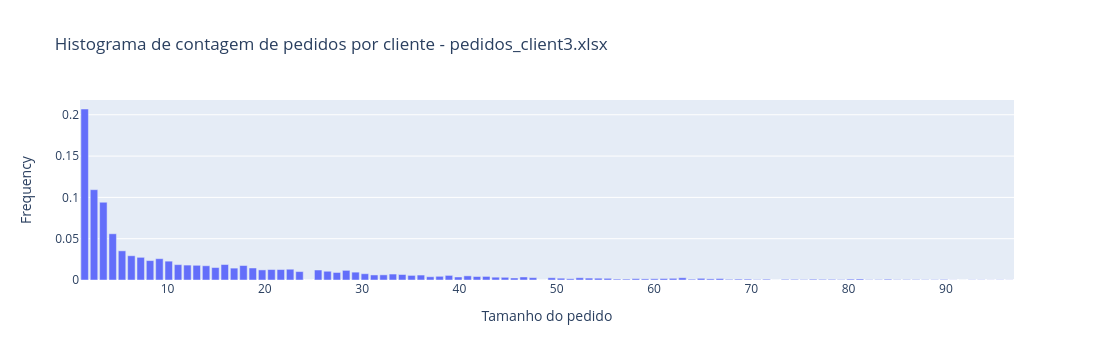

min    : 1
25%    : 1.0
50%    : 2.0
75%    : 4.0
90%    : 7.0
95%    : 9.0
99%    : 16.0
max    : 48


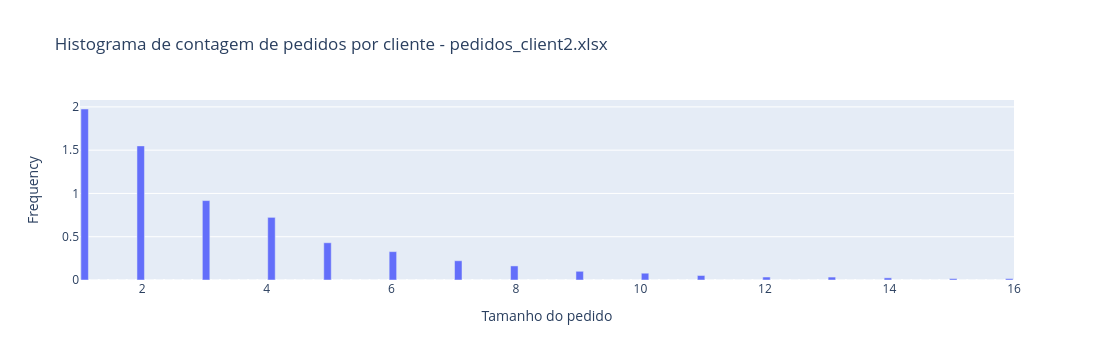

In [320]:
for filename, df in filename_dfs.items():
    orders_len_company = list(map(lambda x: len(x), get_orders_list(df)))

    filename_ = filename.split('/')[-1]
    
    title_ = f'Histograma de contagem de pedidos por cliente - {filename_}'
    x_label = 'Tamanho do pedido'
    bin_count = 100
    is_verbose = True
    
    plot_confidence_histogram(orders_len_company, title_, x_label, bin_count, is_verbose)
    

### Pedidos por cliente

min    : 1
25%    : 3.0
50%    : 12.0
75%    : 52.0
90%    : 132.0
95%    : 285.25
99%    : 1234.75
max    : 83714


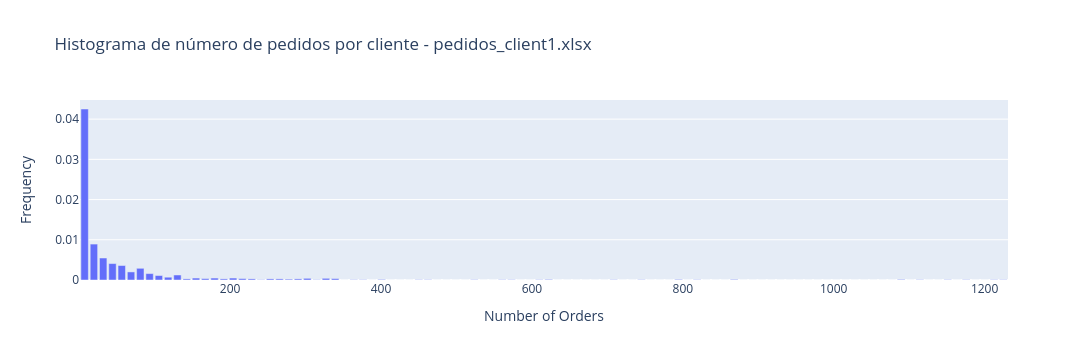

min    : 1
25%    : 1.0
50%    : 3.0
75%    : 10.25
90%    : 37.0
95%    : 87.25
99%    : 346.3
max    : 522


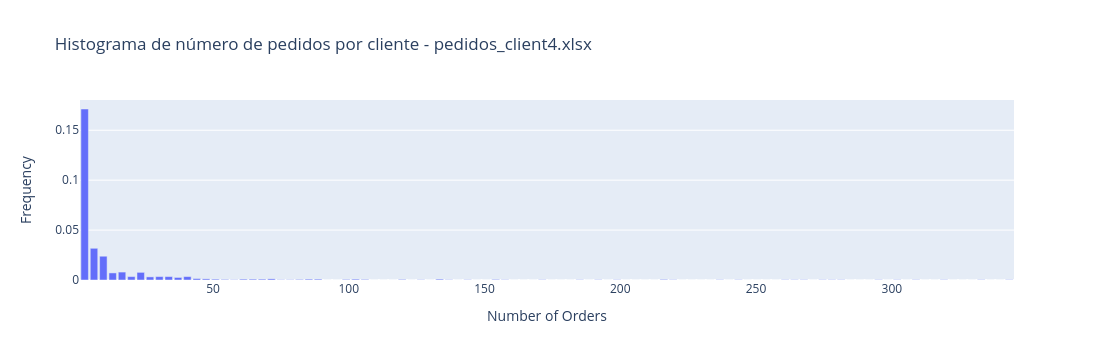

min    : 1
25%    : 1.0
50%    : 1.0
75%    : 2.0
90%    : 5.0
95%    : 8.0
99%    : 38.0
max    : 368


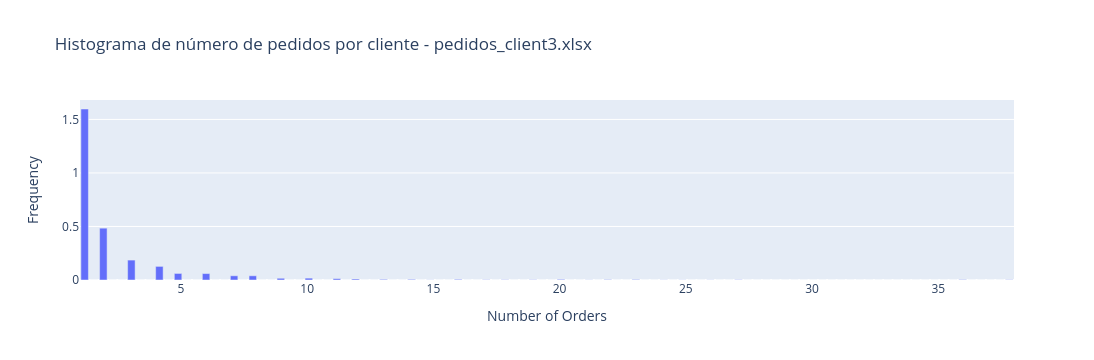

min    : 1
25%    : 2.0
50%    : 7.0
75%    : 26.5
90%    : 69.0
95%    : 109.3
99%    : 176.22
max    : 362


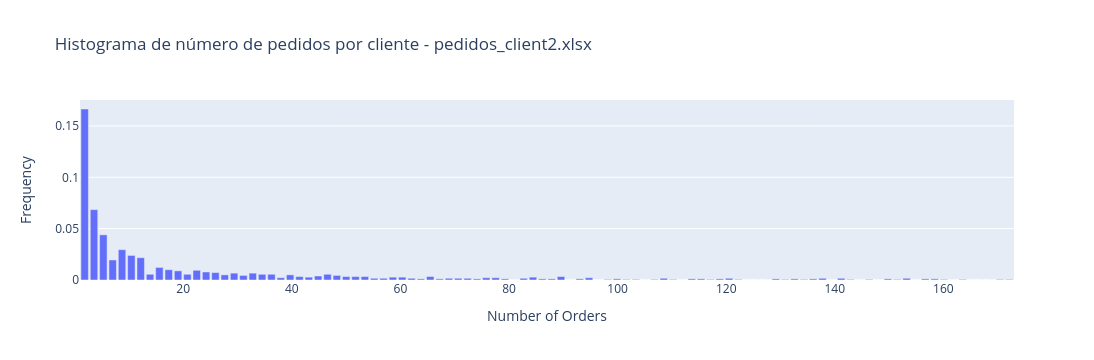

In [57]:
for filename, sv_client_data in analysis_data.items():
    count_client_orders = [
        statistics['orders']['count']
        for client_id, statistics in sv_client_data['clients'].items()
    ]

    filename_ = filename.split('/')[-1]
    
    title_ = f'Histograma de número de pedidos por cliente - {filename_}'
    x_label = 'Número de pedidos'
    bin_count = 100
    is_verbose = True
    
    plot_confidence_histogram(count_client_orders, title_, x_label, bin_count, is_verbose)


### Produtos por cliente

min    : 1
25%    : 11.0
50%    : 52.0
75%    : 234.0
90%    : 657.0
95%    : 1020.75
99%    : 1833.0
max    : 7921


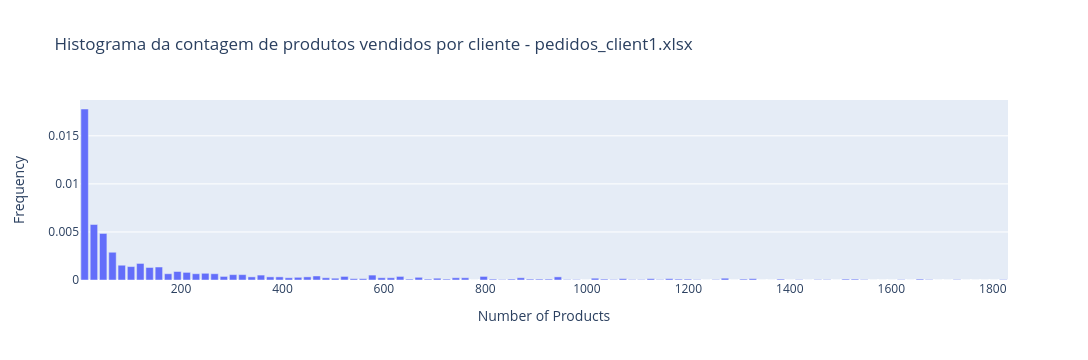

min    : 1
25%    : 14.0
50%    : 43.0
75%    : 143.0
90%    : 454.0
95%    : 1083.25
99%    : 3603.15
max    : 4610


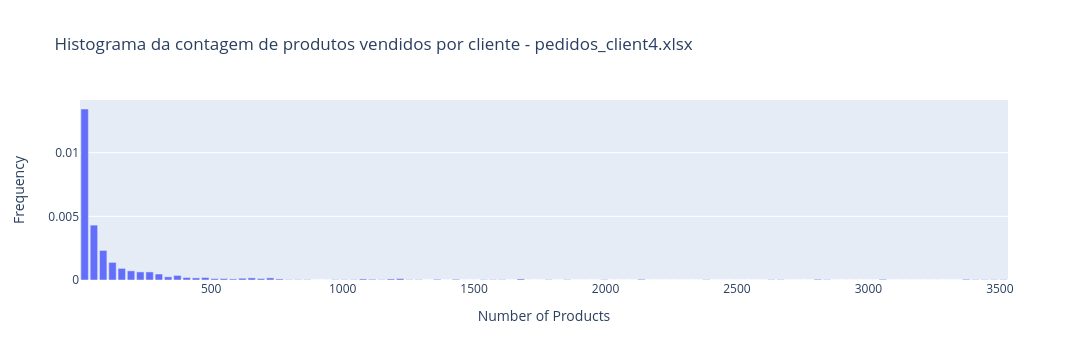

min    : 1
25%    : 1.0
50%    : 15.0
75%    : 38.0
90%    : 80.0
95%    : 126.0
99%    : 292.6
max    : 1940


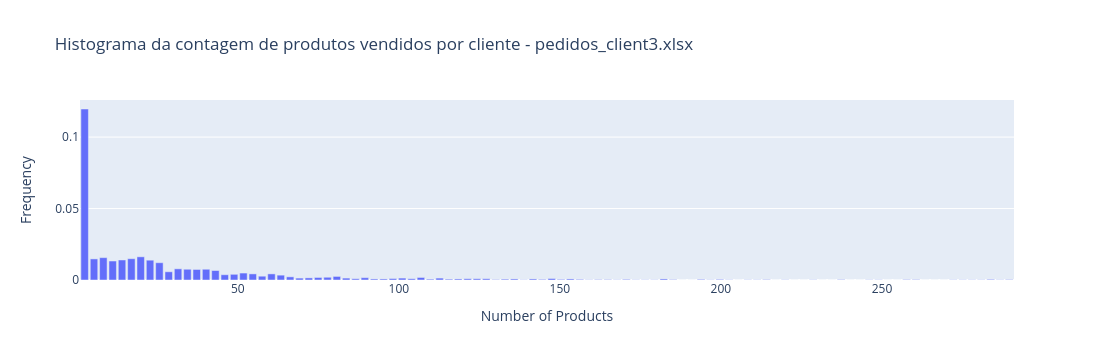

min    : 1
25%    : 5.0
50%    : 17.0
75%    : 52.0
90%    : 121.2
95%    : 183.5
99%    : 385.22
max    : 877


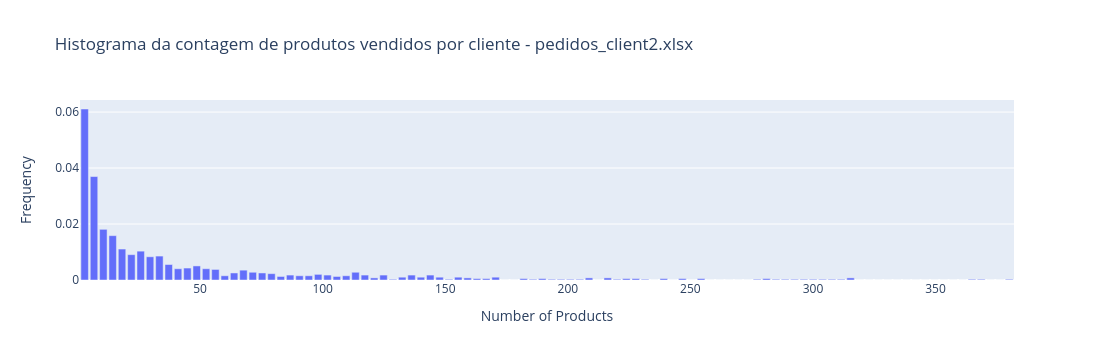

In [327]:
from numpy import quantile

for filename, companies_data in analysis_data.items():
    count_client_orders = [
        statistics['products']['count'] 
        for client_id, statistics in companies_data['clients'].items()
    ]

    filename_ = filename.split('/')[-1]
    
    title_ = f'Histograma da contagem de produtos vendidos por cliente - {filename_}'
    x_label = 'Contagem de produtos'
    bin_count = 100
    is_verbose = True
    
    plot_confidence_histogram(count_client_orders, title_, x_label, bin_count, is_verbose)

### Pedidos por produto

min    : 1
25%    : 4.0
50%    : 14.0
75%    : 51.0
90%    : 158.0
95%    : 297.0
99%    : 947.3
max    : 13375


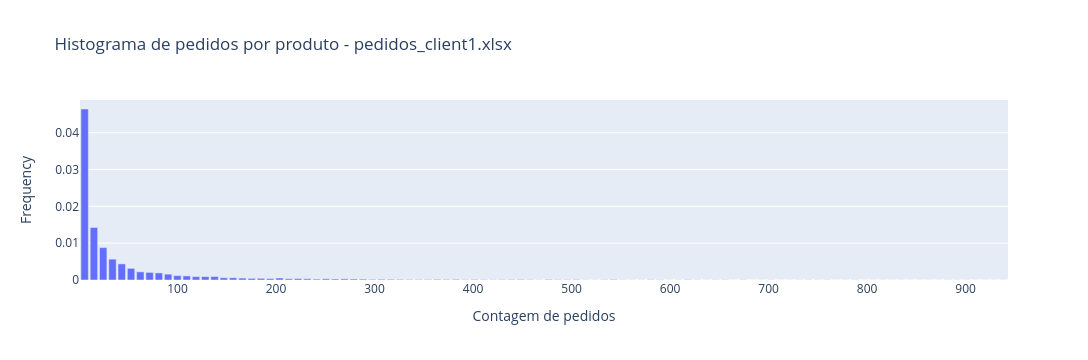

min    : 1
25%    : 1.0
50%    : 3.0
75%    : 10.0
90%    : 26.0
95%    : 46.0
99%    : 158.0
max    : 681


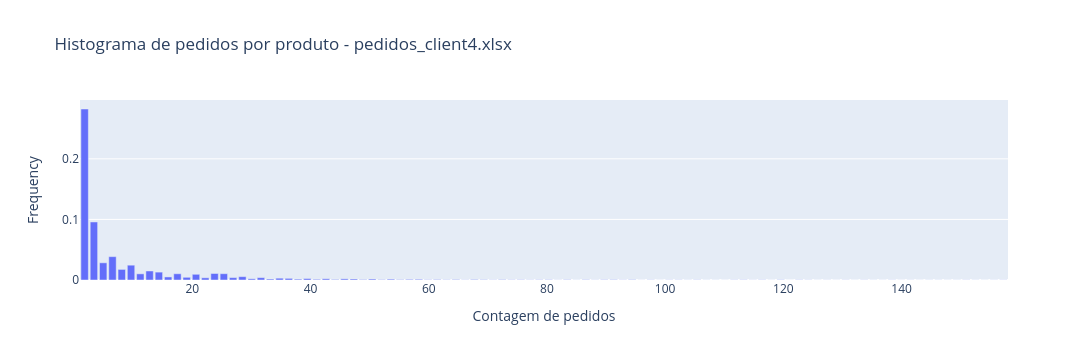

min    : 1
25%    : 1.0
50%    : 2.0
75%    : 6.0
90%    : 19.7
95%    : 38.0
99%    : 132.17
max    : 821


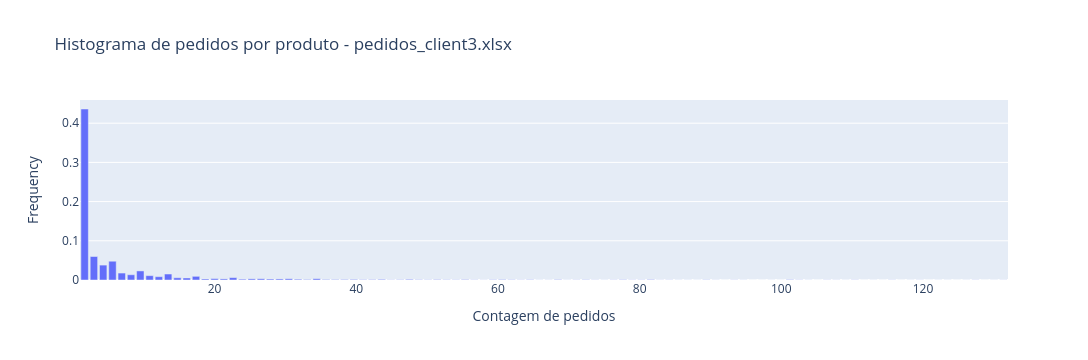

min    : 1
25%    : 1.0
50%    : 3.0
75%    : 11.0
90%    : 36.0
95%    : 70.0
99%    : 224.0
max    : 1360


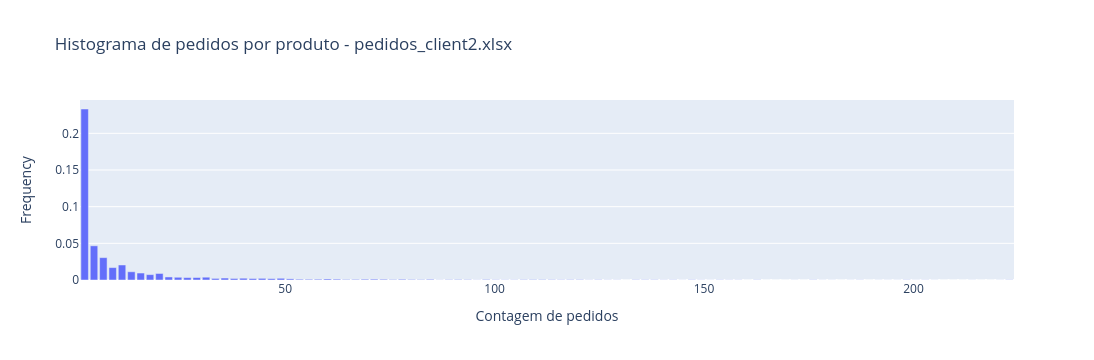

In [334]:
from numpy import quantile, unique

for filename, df in filename_dfs.items():
    products_count_client = list(get_sets_count_per_items_dict(df, 'pedi_id', 'prod_id').values())
    
    filename_ = filename.split('/')[-1]
    
    title_ = f'Histograma de pedidos por produto - {filename_}'
    x_label = 'Contagem de pedidos'
    bin_count = 100
    is_verbose = True
    
    plot_confidence_histogram(products_count_client, title_, x_label, bin_count, is_verbose)

### Vizinhos-amigos do produto

min    : 1
25%    : 1.0
50%    : 1.0
75%    : 2.0
90%    : 4.0
95%    : 7.0
99%    : 21.0
max    : 1358


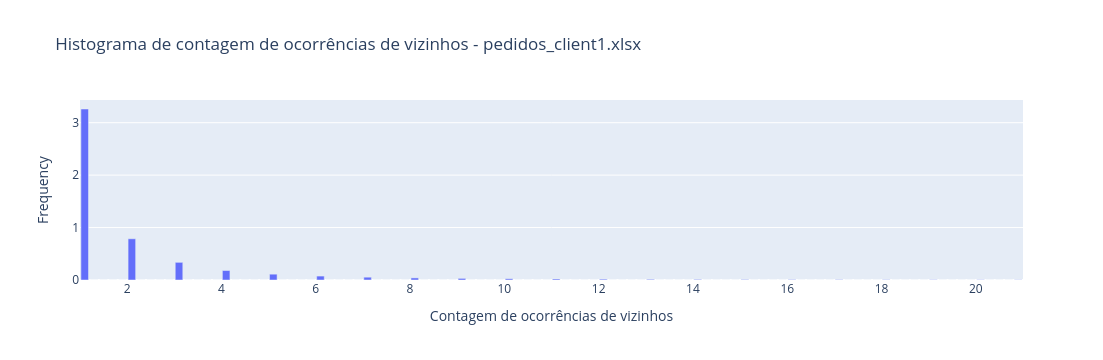

min    : 0
25%    : 58.0
50%    : 222.0
75%    : 740.0
90%    : 1602.0
95%    : 2252.45
99%    : 3507.87
max    : 5980


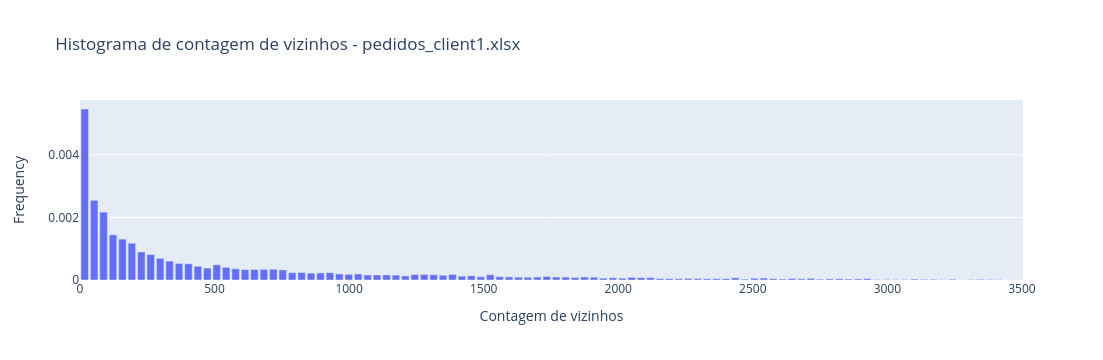

min    : 1
25%    : 1.0
50%    : 1.0
75%    : 3.0
90%    : 9.0
95%    : 19.0
99%    : 43.0
max    : 470


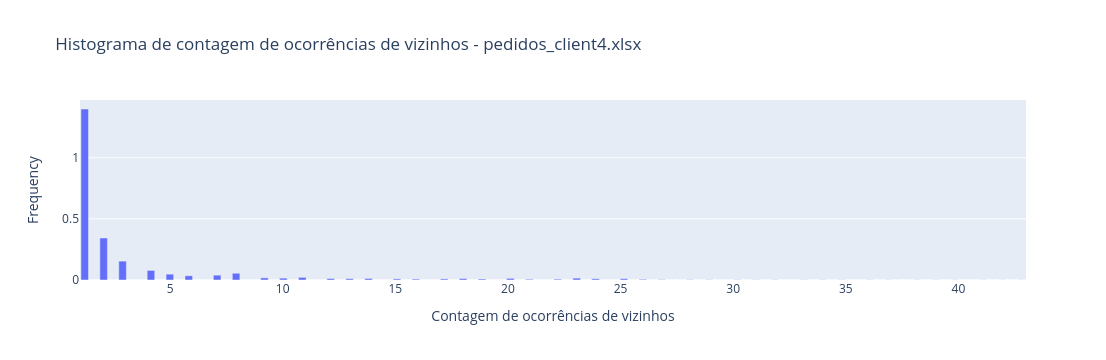

min    : 0
25%    : 34.0
50%    : 85.0
75%    : 184.0
90%    : 305.0
95%    : 413.0
99%    : 580.44
max    : 947


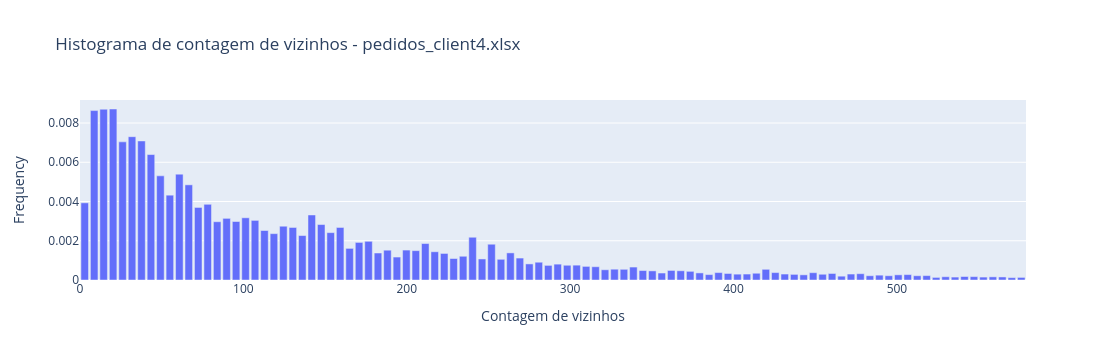

min    : 1
25%    : 1.0
50%    : 1.0
75%    : 2.0
90%    : 3.0
95%    : 5.0
99%    : 13.0
max    : 495


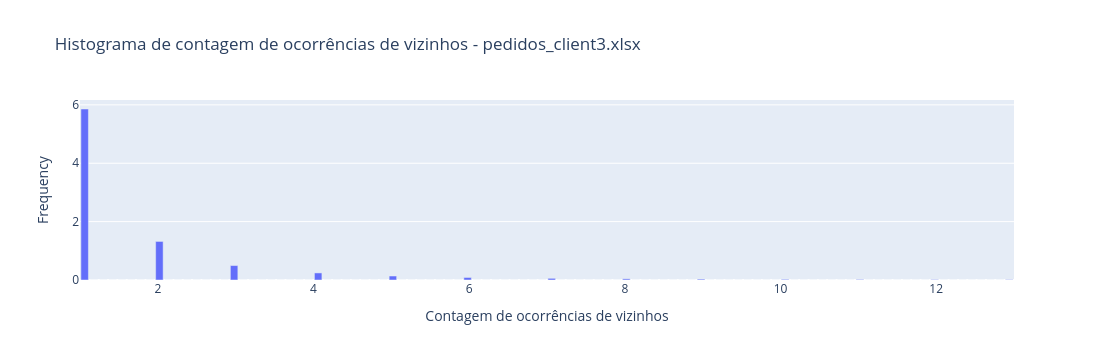

min    : 0
25%    : 29.0
50%    : 77.0
75%    : 304.0
90%    : 693.0
95%    : 982.0
99%    : 1710.34
max    : 3217


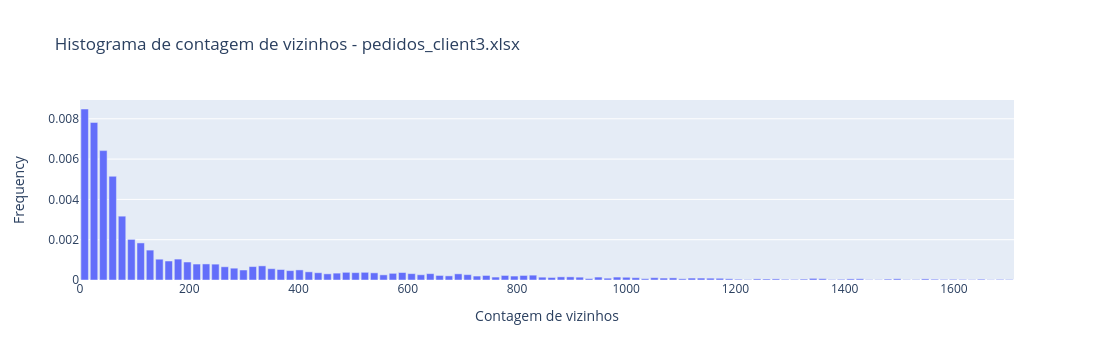

min    : 1
25%    : 1.0
50%    : 1.0
75%    : 3.0
90%    : 6.0
95%    : 11.0
99%    : 34.0
max    : 546


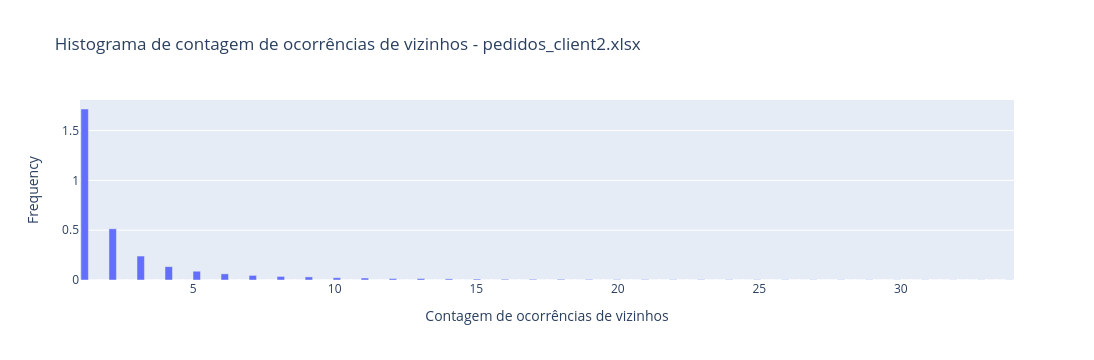

min    : 0
25%    : 7.0
50%    : 15.0
75%    : 32.0
90%    : 63.0
95%    : 95.0
99%    : 174.58
max    : 294


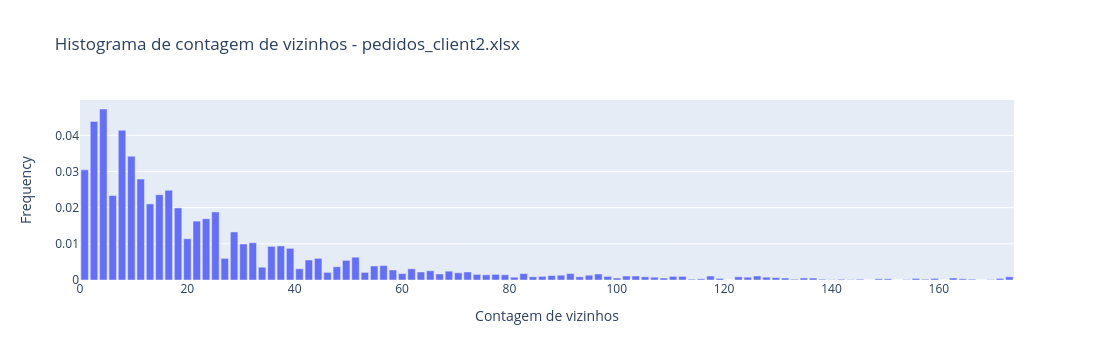

In [423]:
for filename, neighbors_ in neighbors.items():
    filename_ = filename.split('/')[-1]
    
    occurrence_list = flatten_list([
        list(neighbors_dict.values())
        for item_id, neighbors_dict in neighbors_.items()
    ])
    
    title_ = f'Histograma de contagem de ocorrências de vizinhos - {filename_}'
    x_label = 'Contagem de ocorrências de vizinhos'
    bin_count = 100
    is_verbose = True
    
    plot_confidence_histogram(occurrence_list, title_, x_label, bin_count, is_verbose)
    
    neighbors_count_list = flatten_list([
        len(list(neighbors_dict.keys()))
        for item_id, neighbors_dict in neighbors_.items()
    ])
    
    title_ = f'Histograma de contagem de vizinhos - {filename_}'
    x_label = 'Contagem de vizinhos'
    
    plot_confidence_histogram(neighbors_count_list, title_, x_label, bin_count, is_verbose)


### Suporte (_support_), confiança (_confidence_) e incremento (_lift_)

#### Suporte (_support_)

pedidos_client1.xlsx
min    : 5.817707939426025e-06
25%    : 0.0
50%    : 0.0
75%    : 0.0
90%    : 0.0
95%    : 0.0
99%    : 0.01
max    : 0.07781184368982308


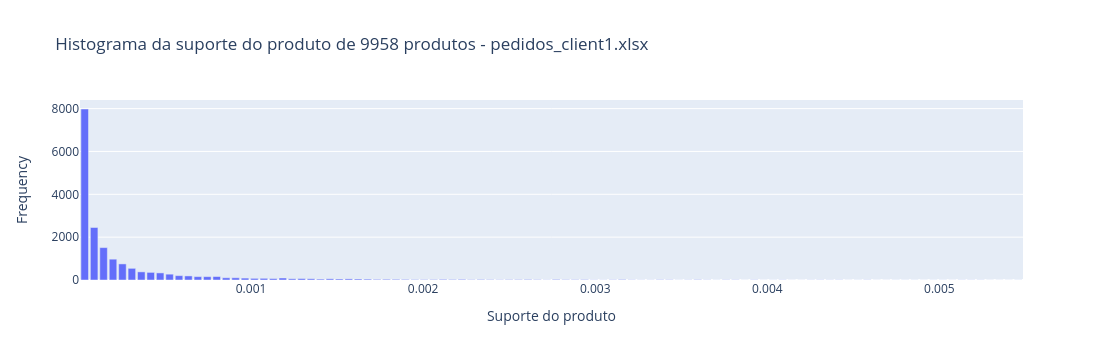

---------------------------------------
pedidos_client4.xlsx
min    : 4.870208931963181e-05
25%    : 0.0
50%    : 0.0
75%    : 0.0
90%    : 0.0
95%    : 0.0
99%    : 0.01
max    : 0.03316612282666927


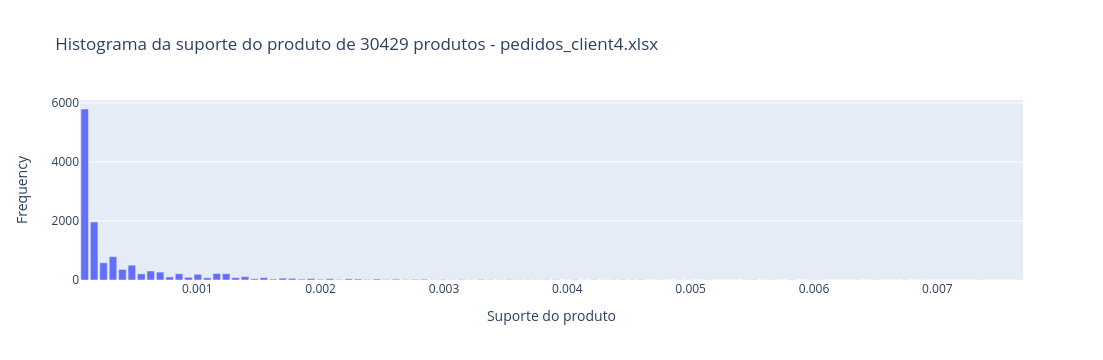

---------------------------------------
pedidos_client3.xlsx
min    : 0.0001290822253775655
25%    : 0.0
50%    : 0.0
75%    : 0.0
90%    : 0.0
95%    : 0.0
99%    : 0.02
max    : 0.10597650703498128


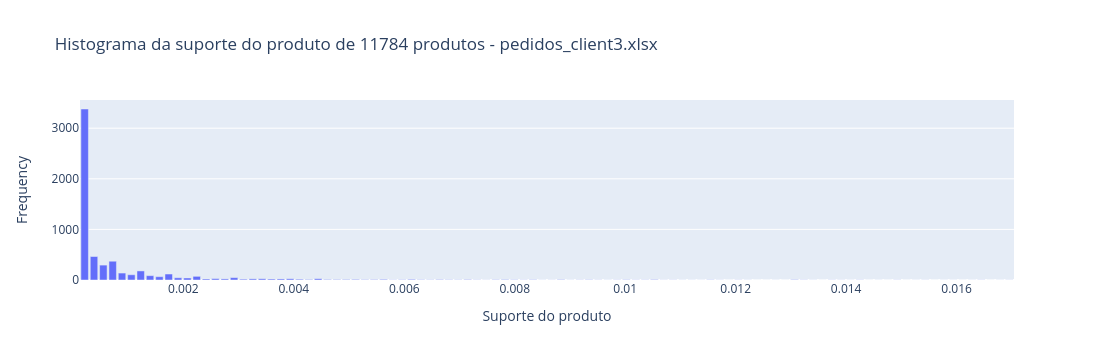

---------------------------------------
pedidos_client2.xlsx
min    : 3.987399816579609e-05
25%    : 0.0
50%    : 0.0
75%    : 0.0
90%    : 0.0
95%    : 0.0
99%    : 0.01
max    : 0.05422863750548267


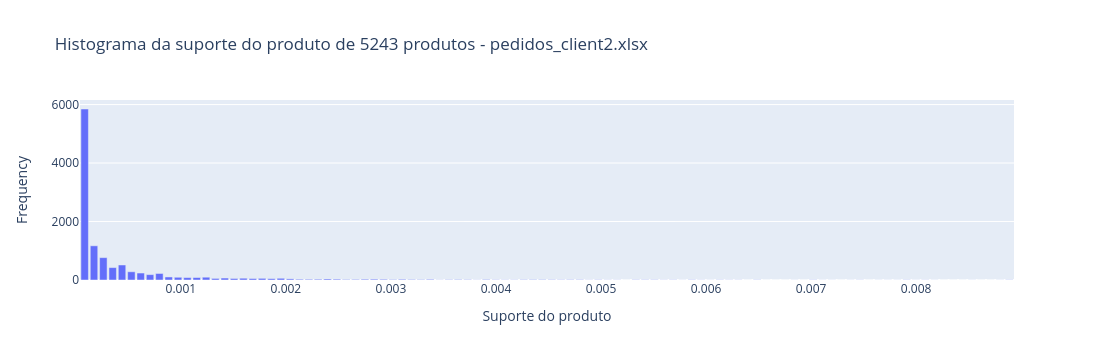

---------------------------------------


In [71]:
for filename, this_metrics in metrics.items():
    filename_ = filename.split('/')[-1]

    product_count = len(this_metrics.keys())
    supports = [
        item_id_metric['support']
        for item_id, item_id_metric in this_metrics.items()
    ]
    
    title_ = f'Histograma da suporte do produto de {product_count} produtos - {filename_}'
    x_label = 'Suporte do produto'
    bin_count = 100
    is_verbose = True

    print(filename_)
    plot_confidence_histogram(supports, title_, x_label, bin_count, is_verbose)
    print('---------------------------------------')

#### Confiança (_confidence_)

pedidos_client1.xlsx
min    : 7.476635514018692e-05
25%    : 0.01
50%    : 0.01
75%    : 0.03
90%    : 0.08
95%    : 0.12
99%    : 0.33
max    : 1.0


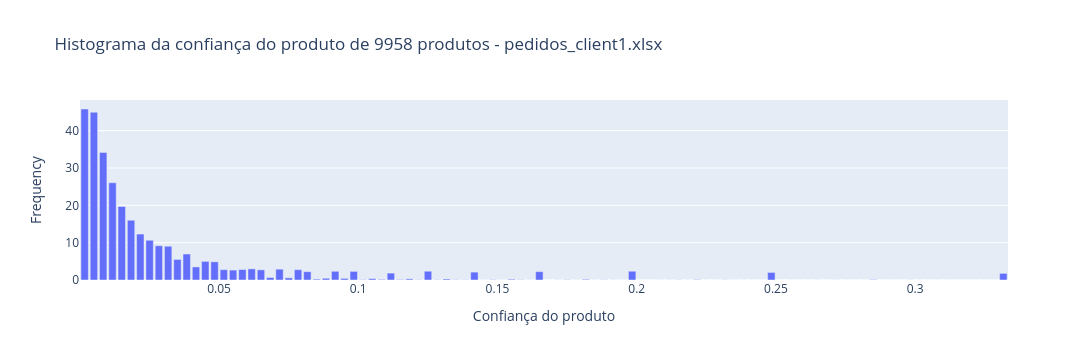

---------------------------------------
pedidos_client4.xlsx
min    : 0.0014684287812041115
25%    : 0.09
50%    : 0.25
75%    : 0.5
90%    : 1.0
95%    : 1.0
99%    : 1.0
max    : 1.0


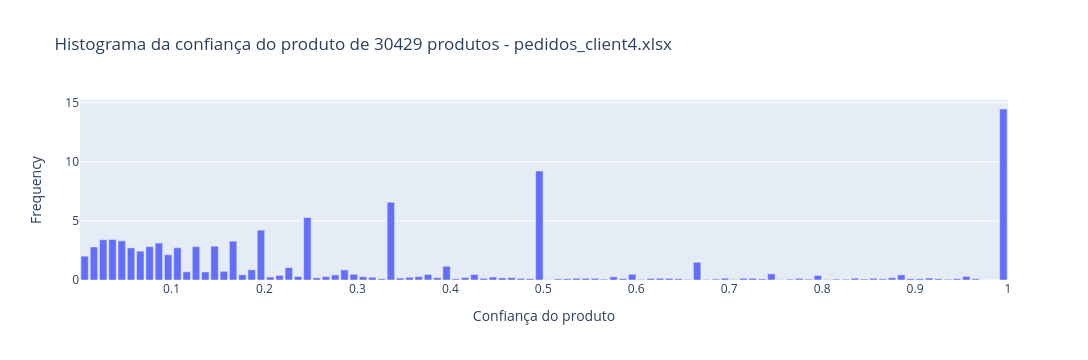

---------------------------------------
pedidos_client3.xlsx
min    : 0.001218026796589525
25%    : 0.03
50%    : 0.09
75%    : 0.25
90%    : 0.5
95%    : 1.0
99%    : 1.0
max    : 1.0


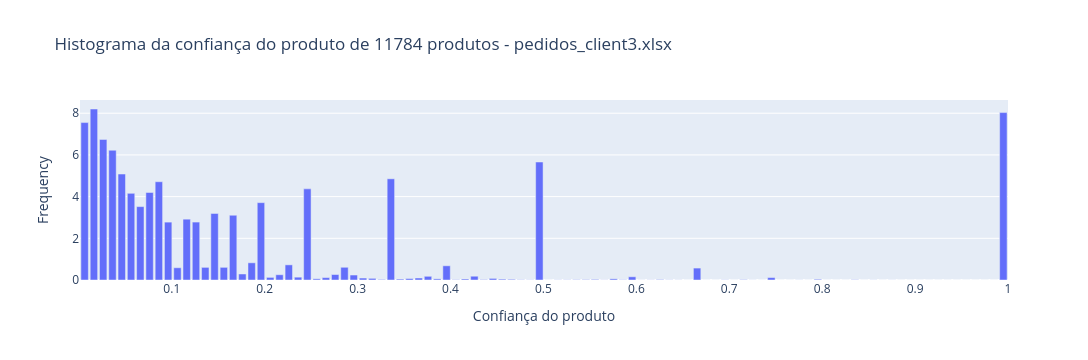

---------------------------------------
pedidos_client2.xlsx
min    : 0.0007352941176470589
25%    : 0.06
50%    : 0.15
75%    : 0.33
90%    : 1.0
95%    : 1.0
99%    : 1.0
max    : 1.0


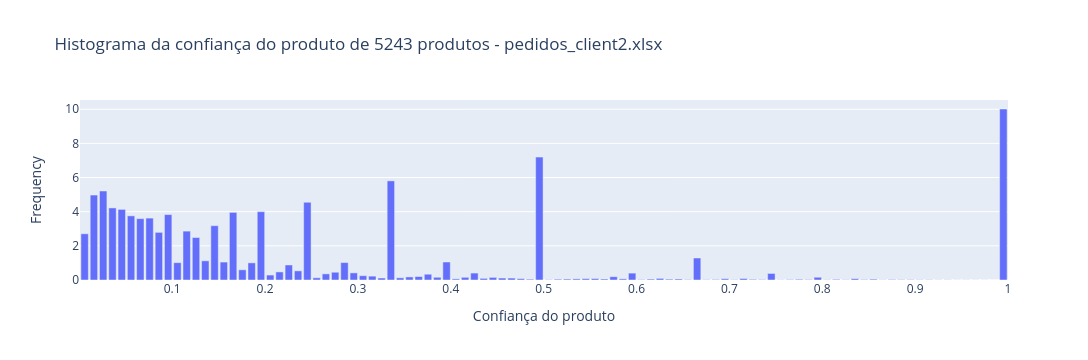

---------------------------------------


In [70]:
for filename, this_metrics in metrics.items():
    filename_ = filename.split('/')[-1]

    product_count = len(this_metrics.keys())
    confidences = flatten_list(
        [
            [
                neighbor_metric['confidence']
                for neighbor_id, neighbor_metric in item_id_metric['neighbors'].items()
            ] 
            for item_id, item_id_metric in this_metrics.items()
        ]
    )
    
    title_ = f'Histograma da confiança do produto de {product_count} produtos - {filename_}'
    x_label = 'Confiança do produto'
    bin_count = 100
    is_verbose = True

    print(filename_)
    plot_confidence_histogram(confidences, title_, x_label, bin_count, is_verbose)
    print('---------------------------------------')

#### Incremento (_Lift_)

pedidos_client1.xlsx
min    : 0.018043639850254447
25%    : 6.68
50%    : 15.52
75%    : 48.6
90%    : 177.94
95%    : 427.58
99%    : 2455.56
max    : 171889.0


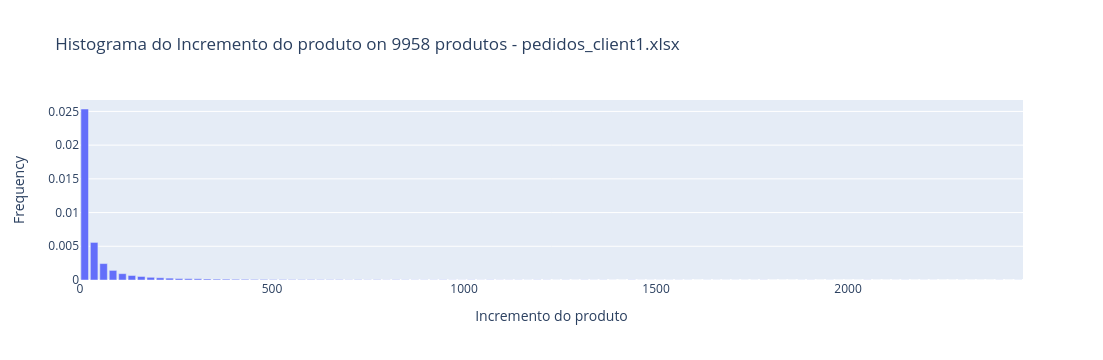

---------------------------------------
pedidos_client4.xlsx
min    : 0.13166737203903914
25%    : 127.53
50%    : 456.29
75%    : 1539.98
90%    : 5133.25
95%    : 10266.5
99%    : 20533.0
max    : 20533.0


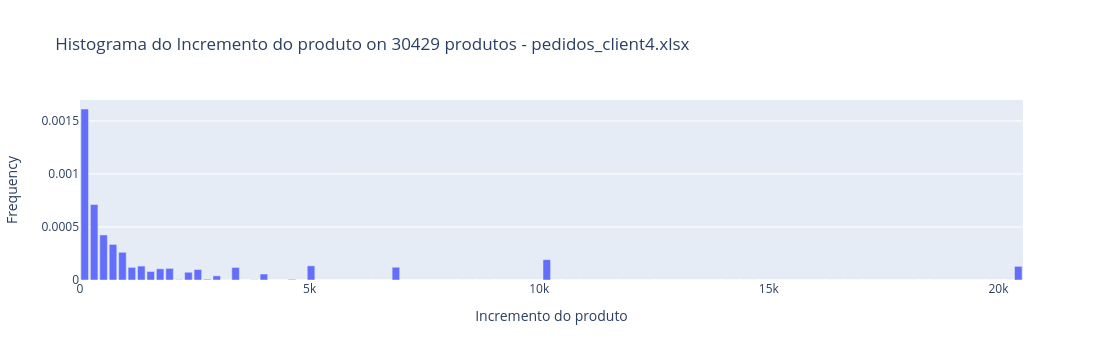

---------------------------------------
pedidos_client3.xlsx
min    : 0.06595998297147722
25%    : 8.97
50%    : 35.87
75%    : 172.16
90%    : 968.38
95%    : 2582.33
99%    : 7747.0
max    : 7747.000000000001


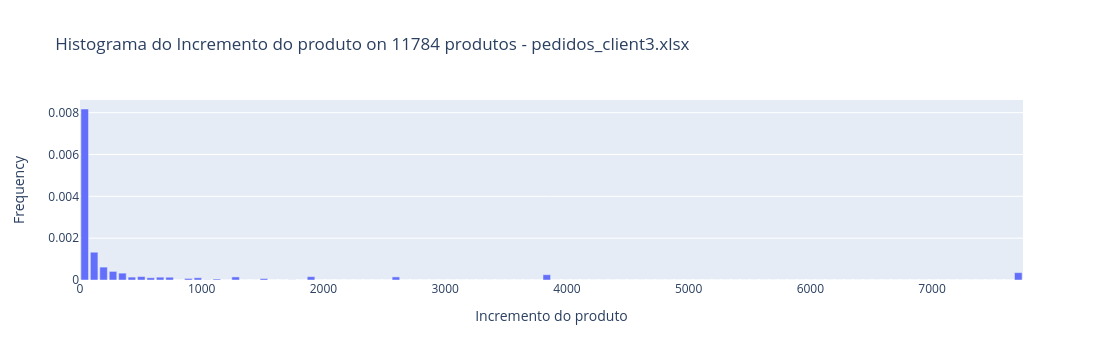

---------------------------------------
pedidos_client2.xlsx
min    : 0.07926133580271104
25%    : 63.33
50%    : 219.99
75%    : 1023.63
90%    : 4179.83
95%    : 12539.5
99%    : 25079.0
max    : 25079.0


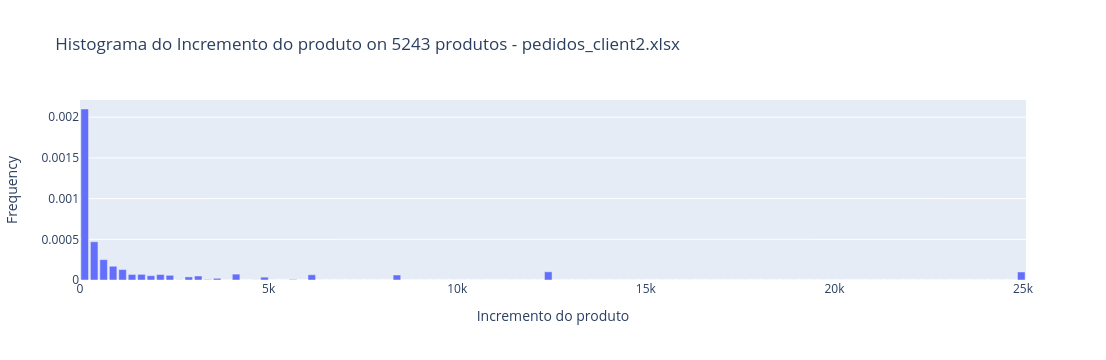

---------------------------------------


In [69]:
for filename, this_metrics in metrics.items():
    filename_ = filename.split('/')[-1]

    product_count = len(this_metrics.keys())
    confidences = flatten_list(
        [
            [
                neighbor_metric['lift']
                for neighbor_id, neighbor_metric in item_id_metric['neighbors'].items()
            ] 
            for item_id, item_id_metric in this_metrics.items()
        ]
    )
    
    title_ = f'Histograma do Incremento do produto on {product_count} produtos - {filename_}'
    x_label = 'Incremento do produto'
    bin_count = 100
    is_verbose = True

    print(filename_)
    plot_confidence_histogram(confidences, title_, x_label, bin_count, is_verbose)
    print('---------------------------------------')

## 7. Heurística de associação 

### 7.1. Heurísticas e algoritmos 

#### a. Sugestões de melhores vizinhos arbitrários 

In [15]:
from random import randint

order_size = (5, 10)
n_suggestions = 3
n_best_neighbors = 6
best_neighbors = defaultdict()

suggestions = defaultdict()
orders = defaultdict()

for filename, df, neighbors_i in zip(filenames, list(dfs), list(neighbors.values())):
    sets_factory = sets_factory_gen(listify_items(df, 'pedi_id', 'prod_id'))
    order = next(sets_factory) 
    orders[filename] = order

    suggestions[filename] = get_k_best_random_neighbors(
        order, neighbors_i, n_suggestions, n_best_neighbors,
    )


In [16]:
for filename, order, suggestion in zip(filenames, list(orders.values()), list(suggestions.values())):
    order_descriptions = [repr(descriptions[filename][item_id]) for item_id in order]
    suggestion_descriptions = [repr(descriptions[filename][item_id]) for item_id in suggestion]
    
    print(f'{order_descriptions} -> {suggestion_descriptions}')
    

["'KIT A FAN 125 2009 (VEDAMOTORS) - 84841000'", "'RETENTOR GUIA VALVULA CG VERDE (TRILHA) - 40169300'", "'PISTAO+SEG.0,25 FAN 125 2009 (REDFOX) - 84099120'", "'JUNTA CABECOTE T.150/ BROS 06/08 (MHX)'", "'RETENTOR GUIA VALVULA TITAN (ORIGINAL) 12209GB4682'", "'PISTAO+SEG.0,25 T.150 (KMP)'", "'ANEL TAMPA VALVULA T.150/BROS 06/15/FAN 125/150 09/15 (TRILHA)'", "'JUNTA CILINDRO T.150/BROS 2006... (VALFLEX) - 84842000'", "'ANEL CUBA CARBURADOR CG (TRILHA)'", "'MANICOTO EMBREAGEM TITAN/KS/T.150 (COMETA) 2502'"] -> ["'OLEO 4T 20w50 1LT (IPIRANGA)'", "'PISTAO+SEG.0,50 FAN 125 2009 (REDFOX) - 84099120'", "'KIT CILINDRO TITAN 95/2001 (METAL LEVE) - K9023'"]
["'SL0803 - JARRA DE VIDRO 1.8 LITROS CX12'", "'SL0829 - VASO PARA DECORACAO CX15'", "'SL0833 - VASO PARA DECORACAO CX8'", "'SL0800 - JARRA DE VIDRO 1.8 LITROS CX12'", "'SL0830 - VASO PARA DECORACAO CX15'", "'SL0809 - JARRA DE VIDRO 1.8 LITROS CX12'", "'sl0852 jarra 1,2 litros'", "'SL0831 - VASO PARA DECORACAO CX15'", "'SL0808 - JARRA DE VIDR

#### b. Sugestões baseado em métrica suporte

In [18]:
order_size = (5, 10)
n_suggestions = 3
n_best_neighbors = 6
best_neighbors = defaultdict()

suggestions = defaultdict()
orders = defaultdict()

for filename, df, neighbors_i in zip(filenames, dfs, list(neighbors.values())):
    sets_factory = sets_factory_gen(listify_items(df, 'pedi_id', 'prod_id'))
    order = next(sets_factory)
    orders[filename] = order
    
    sets_count_dict = get_sets_count_per_items_dict(df, 'pedi_id', 'prod_id')
    suggestions[filename] = get_k_best_support_based_neighbors(
        order, neighbors_i, sets_count_dict, 
        n_suggestions, n_best_neighbors
    )



In [19]:
for filename, order, suggestion in zip(filenames, list(orders.values()), list(suggestions.values())):
    order_descriptions = [repr(descriptions[filename][item_id]) for item_id in order]
    suggestion_descriptions = [repr(descriptions[filename][item_id]) for item_id in suggestion]
    
    print(f'{order_descriptions} -> {suggestion_descriptions}')
    

["'BUCHA COROA T.150 04/15/T.160 C/4 (TRIBAL)'"] -> ["'LONA FREIO TRAS.T.2000/T.150 (DIAFRAG) DFH00127'", "'OLEO 4T 20w50 1LT PRETO (MOBIL)'", "'LONA FREIO TRAS.T.2000/T.150 (FIREBREQ) FBQ00100'"]
["'JARRA KARAT C/ 7 PCS*'", "'COPO LONG DRINK KARAT 330ML*'", "'COPO WHISKY KARAT 300ML*'", "'COPO LONG DRINK CASA BLANCA 421ML'", "'COPO WHISKY BAROQUE 300ML*'", "'JARRA  ANTALYA 1850ML H 24CM D 11,2CM*'", "'TACA VINHO TINTO CASA BLANCA 235ML*'", "'PRATO PARA BOLO H12X32D*'"] -> ["'JARRA  BISTRO 1850ML H 24CM D 11,2CM*'"]
["'MANGUEIRA DE FILTRO DE AR FIAT'", "'MANGUEIRA DE FILTRO DE AR FIAT'", "'Fiat Palio 1.0/1.5 8V MPI'", "'MOLA ACELERACAO FUSCA'", '\'RETO 5/16"X5/16" BARTOLOMEU\'', "'MANGUEIRA DO FILTRO DE AR S10 / BLAZER - 4.3 6V TODOS'", "'KIT REPARO BICO INJETOR FIAT PALIO UNO ESCORT FIESTA KÁ ASTRA'", "'FLANGE DE COMBUSTIVEL UNO   '", "'KIT CAPA CORREIA DENTADA FIAT'", "'MANGUEIRA DE FILTRO DE AR FIAT'", '\'90° 3/8"X3/8" BARTOLOMEU\'', "'KIT DE REPARO PARA BICO COM PONTAS LONGAS'", "'

#### c. FP Growth

NOTA: Quebra com base grande de dados 

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

min_supports = [0.01] * len(filenames)
suggestions = defaultdict()

with about_time() as t:
    for filename, df_, min_support in zip(filenames, dfs, min_supports):
        dataset = listify_items(df_, 'pedi_id', 'prod_id')
        encoded_dataset = pd.get_dummies(df.stack()).sum(level=0)
        
        te = TransactionEncoder()
        te_ary = te.fit(dataset).transform(dataset)
        df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
        # Documentation: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/
        suggestions[filename] = fpgrowth(df_encoded, min_support=min_support)

print(f'Regras de associação demorou: {t.duration_human}')

### 7.2. Encapsulamento em classe

In [60]:
from timy import Timer

In [62]:
class SVRecommender(object):

    def __init__(
        self, 
        df_: pd.DataFrame,
        sets_column: str,
        items_column: str,
        description_column: str,
        n_suggestions: int = N_SUGGESTIONS_DEFAULT,
        n_best_neighbors: int = N_BEST_NEIGHBORS_DEFAULT
    ):
        if(n_suggestions <= 0 or n_best_neighbors <= 0):
            raise ValueError('Number of provided suggestions or best neighbors must be greater than 0!')

        self.data_dataframe = df_
        
        self.__sets_column = sets_column
        self.__items_column = items_column
        
        self.descriptions_dict = get_descriptions(df_, items_column, description_column)
        self.order_list = listify_items(df_, sets_column, items_column)
        self.orders_per_product_dict = get_sets_count_per_items_dict(df_, sets_column, items_column)
        self.neighbors_dict = {}
        self.n_suggestions = n_suggestions
        self.n_best_neighbors = n_best_neighbors

    def _update_neighbors(self):
        self.neighbors = get_items_neighbors_count(self.data_dataframe, self.__sets_column, self.__items_column)
 
    @timer()
    def suggest(
        self, 
        order: list, 
        method: str = 'k_best_support'
    ):
        if(len(order) == 0):
            raise ValueError('Order cannot be empty!')

        if(len(self.neighbors_dict) == 0):
            error_message = 'You must run method \'_update_neighbors\' before running \'suggest\''
            raise ValueError(error_message)

        methods = ['k_best_arbitrary', 'k_best_random', 'k_best_support']
        if(method == 'k_best_arbitrary'):
            return get_k_best_arbitrary_neighbors(
                order, 
                self.neighbors_dict, 
                self.n_suggestions, 
                self.n_best_neighbors
            )
        
        elif(method == 'k_best_random'):
            return get_k_best_random_neighbors(
                order, 
                self.neighbors_dict, 
                self.n_suggestions, 
                self.n_best_neighbors
            )
        
        elif(method == 'k_best_support'):
            return get_k_best_support_based_neighbors(
                order, 
                self.neighbors_dict, 
                self.orders_per_product_dict, 
                self.n_suggestions, 
                self.n_best_neighbors
            )

        else:
            raise ValueError(f'Available methods are: {methods}')    

    def describe(self, item_ids: list):
        described_items = []
        
        for item_id in item_ids:
            try:                
                described_items.append(self.descriptions_dict[item_id])
            except Exception as e:
                described_items.append('')

        return described_items

In [66]:
sets_column_ = 'pedi_id'
items_column_ = 'prod_id'
description_column = 'prod_descricao'


for filename_, df_, neighbor_i_list in zip(filenames, dfs, list(neighbors.values())):
    print(filename_)
    
    recommender = SVRecommender(df_, sets_column_, items_column_, description_column)
    recommender.neighbors_dict = neighbor_i_list
    
    sets_factory = sets_factory_gen(listify_items(df_, sets_column_, items_column_))
    order = next(sets_factory)
    
    suggestions_arbitrary = recommender.suggest(order, 'k_best_arbitrary')
    suggestions_random = recommender.suggest(order, 'k_best_random')
    suggestions_support = recommender.suggest(order, 'k_best_support')

    print('---------------------------------------------')

/home/brunolnetto/Documents/sv_notebooks/associatividade/data/pedidos_client1.xlsx
Timy executed (suggest) for 1 time in 0.673935 seconds
Timy best time was 0.673935 seconds
Timy executed (suggest) for 1 time in 0.653363 seconds
Timy best time was 0.653363 seconds
Timy executed (suggest) for 1 time in 0.654379 seconds
Timy best time was 0.654379 seconds
---------------------------------------------
/home/brunolnetto/Documents/sv_notebooks/associatividade/data/pedidos_client4.xlsx
Timy executed (suggest) for 1 time in 0.452844 seconds
Timy best time was 0.452844 seconds
Timy executed (suggest) for 1 time in 0.447575 seconds
Timy best time was 0.447575 seconds
Timy executed (suggest) for 1 time in 0.445063 seconds
Timy best time was 0.445063 seconds
---------------------------------------------
/home/brunolnetto/Documents/sv_notebooks/associatividade/data/pedidos_client3.xlsx
Timy executed (suggest) for 1 time in 0.312182 seconds
Timy best time was 0.312182 seconds
Timy executed (suggest

## 8. Treino do modelo - Apriori e Regras de associação

In [19]:
dfs = [df for df in filename_dfs.values()]

In [62]:
from itertools import combinations
from collections import defaultdict

def generate_frequent_itemsets(data, min_support):
    item_counts = defaultdict(int)
    total_transactions = len(data)

    # Count the occurrences of each item
    for transaction in data:
        for item in transaction:
            item_counts[item] += 1

    # Filter items that meet the minimum support
    frequent_itemsets = {
        (item, ): count/total_transactions 
        for item, count in item_counts.items() 
        if count/total_transactions >= min_support
    }

    return frequent_itemsets

def generate_candidate_itemsets(frequent_itemsets, k):
    candidate_itemsets = []
    frequent_items = list(frequent_itemsets.keys())
    
    for i in range(len(frequent_items)):
        for j in range(i+1, len(frequent_items)):
            itemset1 = frequent_items[i]
            itemset2 = frequent_items[j]
            candidate_itemset = set(itemset1).union(set(itemset2))
            print(candidate_itemset)
            
            if len(candidate_itemset) == k+1:
                candidate_itemsets.append(candidate_itemset)
    return candidate_itemsets

# Example dataset and minimum support threshold
data = [
    ['apple', 'banana', 'orange'],
    ['banana', 'orange', 'grape'],
    ['apple', 'banana', 'grape'],
    ['apple', 'grape'],
    ['banana', 'orange']
]
min_support = 0.4

# Generate frequent itemsets of length 1
frequent_itemsets_1 = generate_frequent_itemsets(data, min_support)

# Generate candidate itemsets of length 2
candidate_itemsets_2 = generate_candidate_itemsets(frequent_itemsets_1, k=1)

print("Candidate Itemsets of Length 1:")
print(frequent_itemsets_1)

print("Candidate Itemsets of Length 2:")
print(candidate_itemsets_2)


{'apple', 'banana'}
{'orange', 'apple'}
{'apple', 'grape'}
{'orange', 'banana'}
{'grape', 'banana'}
{'orange', 'grape'}
Candidate Itemsets of Length 1:
{('apple',): 0.6, ('banana',): 0.8, ('orange',): 0.6, ('grape',): 0.6}
Candidate Itemsets of Length 2:
[{'apple', 'banana'}, {'orange', 'apple'}, {'apple', 'grape'}, {'orange', 'banana'}, {'grape', 'banana'}, {'orange', 'grape'}]


In [20]:
dfs_max_years = []
for df in dfs:
    df['pedi_ano'] = pd.to_datetime(df['pedi_data']).dt.year
    years = get_years(df, 'pedi_data')

    max_year = list(
        max(
            [(year, len(df[df['pedi_ano'] == year])) for year in years], 
            key=lambda x: x[1]
        )
    )[0]

    dfs_max_years.append(df[df['pedi_ano'] == max_year])

filenames = list(filename_dfs.keys())
filename_dfs_max_years = dict(zip(filenames, dfs_max_years))



In [ ]:
training_dfs = filename_dfs_max_years

# Importando as bibliotecas necessárias
min_supports_thres = [
    (0.01, 0.01),
    (0.01, 0.01),
    (0.01, 0.01),
    (0.01, 0.01),
]

rules_dict = dict()
for filename_df, min_supports_thres in tqdm(zip(training_dfs.items(), min_supports_thres)):
    filename, df = filename_df
    min_support_, min_threshold_ = min_supports_thres
    
    # Exibindo as regras encontradas
    rules_dict[filename] = get_frequent_items_and_rules_dict(
        filename, df, min_support_, min_threshold_
    )
    

1it [00:02,  2.34s/it]

Comprimento de pedidos originais : 36750
Comprimento de pedidos de treino : 34907
Número de regras                 : 2

Timy executed (get_association_rules) for 1 time in 2.216555 seconds
Timy best time was 2.216555 seconds
Directory 'rules' already exists.


In [11]:
suggestions = dict()
for filename, df in tqdm(zip(filenames, dfs)):
    frequent_itens = rules_dict[filename]['frequent_itens']
    rules = rules_dict[filename]['rules']

    product_ids = get_unique_elements(df, 'prod_id')

    # Filter rules for relevant suggestions
    order = sample(set(product_ids), SAMPLE_COUNT)

    is_subset_map = lambda x: len(set(order).intersection(set(x))) != 0 
    antecedents_subset_mask = rules['antecedents'].apply(is_subset_map)
    relevant_rules = rules[antecedents_subset_mask]

    try:
        # Rank rules based on confidence
        relevant_rules = relevant_rules.sort_values(by='confidence', ascending=False)

        # Get suggestions from the top-ranked rules
        suggestion = relevant_rules.iloc[0]['consequents']

    except Exception as e:
        suggestion = ()

    suggestions[filename] = tuple(suggestion)

suggestions

2it [00:00,  5.33it/s]

Suggestions: ['sv697406_pedido_pedido_item.xlsx']
Suggestions: ['sv697406_pedido_pedido_item.xlsx', 'calasans_pedido_pedido_item.xlsx']


4it [00:00,  5.83it/s]


{'sv697406_pedido_pedido_item.xlsx': (),
 'calasans_pedido_pedido_item.xlsx': frozenset({'400.LCS10'}),
 'fatalkits_pedido_pedido_item.xlsx': frozenset({'10.FTS-1684D'}),
 'cassioreis_pedido_pedido_item.xlsx': ()}